In [13]:
import os
import scipy as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


## Label statemment

#### Location
- Area:Mouse 1 Center In Center (10) #
- Area:Mouse 1 Center In Close Arm (11) #
- Area:Mouse 1 Center In Open Arm (12) #
 
- AreaStay:Mouse 1 Nose In Close Arm while TailBase In Open Arm (12)
- AreaStay:Mouse 1 Nose In Open Arm while TailBase In Close Arm (11)
 
#### Action
- Mouse 1 Grooming (31)
- Mouse 1 HeadDip [None] (32) #
- Mouse 1 SAP [Center In Close Arm] (33)
- Mouse 1 SAP [Center In Open Arm] (34)
- Mouse 1 SAP [None] (35)

# Define functions


In [14]:
# get rid of incorrect neuron and non-target neuron for trace file
#----------------------------------------------------------------------------------
def process_(trace_path, incorrect_neuron_path, position_path):
    
    #read csv
    df = pd.read_csv(trace_path)
    
    #profecc column in df file
    column_list = df.columns.tolist()
    column_list = [column.strip() for column in column_list]
    column_list[0] = 'Frame'
    df.columns = column_list
    
    # drop the first row, cell-undecide
    #df =df.drop([0])
    
    #read and process incorrect neuron list
    with open(incorrect_neuron_path) as f:
        df_in_list = [line.rstrip('\n').replace(' ', '') for line in open(incorrect_neuron_path)]
    
    #fix 78 to 078
    new_df_in_list = []
    for i in df_in_list:
        if len(i) < 3:
            sup0 = '0'*(3-len(i))
            i = sup0+i
        new_df_in_list.append(i)
        
    new_df_in_list = ["C" + neuron for neuron in new_df_in_list]
    print('%i neurons are not correct'%len(new_df_in_list))
    
    # get cells that are not our target
    position = pd.read_csv(position_path, names =['x','y','L'] )
    position['C'] = df.columns[1:]
    position_no = position[(position['L'] == 0)]
    position_no_c_list = position_no['C'].values.tolist()
    print('%i neurons are not our target'%len(position_no_c_list))

    # merge incorrect neuron list and non-target neuron list
    non_list = list(set(new_df_in_list+position_no_c_list))
    print('%i neurons are removing'%len(non_list))
    print(' ')
    # rule out incorrect neurons
    df = df.drop(columns = non_list)


    #convert object dtype to float
    df = df.astype('float')
    
    #set Frame as index
    df = df.set_index('Frame')
    
    #shape(frames, neurons)
    return(df)

In [15]:
# process frame list
# event file always start from 10.1s, but some trace frame start from 0, some from 741.19
#----------------------------------------------------------------------------------
def process_frame(df):
    # get frame list
    frame_list = df.index.values.tolist()
    
    # get starting value
    a = frame_list[0]
    new_frame_list = [(i-a) for i in frame_list]
    
    return(new_frame_list)


# process event_label list
# event+label starts from 10, but trace start from 0, deduct 10 from event_start&end time
#----------------------------------------------------------------------------------
def process_event_interval(df):
    event_list = df[['From Second','To Second']].values.tolist()
    new_event_list = []
    
    startTime = df['From Second'].values.tolist()[0]
    
    for event in event_list:
        new_event = [x-startTime for x in event]
        new_event_list.append(new_event)
    return(new_event_list)


    
# get enevt label for an event file based on different mice and session
# for each session, we have separate event file
#----------------------------------------------------------------------------------
def get_event_label(event_df):
    
    # get event status list
    Event_status = event_df['Event'].values.tolist()
    # compact event label list for three sessions
    event_label = []

    for i in Event_status:   
        if i == 'Area:Mouse 1 Center In Center':
            event_label.append(10)
        elif i == 'Area:Mouse 1 Center In Close Arm' :
            event_label.append(11)
        elif i == 'Area:Mouse 1 Center In Open Arm':
            event_label.append(12)
       
        elif i == 'AreaStay:Mouse 1 Nose In Close Arm while TailBase In Close Arm':
            event_label.append(11)
        elif i == 'AreaStay:Mouse 1 Nose In Open Arm while TailBase In Open Arm':
            event_label.append(12)
        
        
        elif i == 'Mouse 1 Grooming':
            event_label.append(31)
        elif i == 'Mouse 1 HeadDip [None]':
            event_label.append(32)
        elif i == 'Mouse 1 SAP [Center In Close Arm]':
            event_label.append(33)
        elif i == 'Mouse 1 SAP [Center In Open Arm]':
            event_label.append(34)
        elif i ==  'Mouse 1 SAP [None]':
            event_label.append(35)

        else:
            event_label.append(90)
                
    return(event_label)



# process events file, add event label for string label
#----------------------------------------------------------------------------------
def add_event_label(trace_df, event_path):

    frame_list = process_frame(trace_df)

    #get event dataframe
    event_df = pd.read_excel(event_path, skiprows = 6)
    # get event intervals
    interval_list = process_event_interval(event_df)
    # get event label
    event_label = get_event_label(event_df)

    # deal with session 1
    frame_label_list = []
    for frame in frame_list:
        frame_label = str()
        if frame > 5:
            #begin to define frame label
            for i in range(len(interval_list)):
                if min(interval_list[i])  <= frame <= max(interval_list[i]) :
                    frame_label = frame_label+ str(event_label[i])

        # convert str to int
        if len(frame_label) == 0:
            frame_label = np.nan
        else:
            frame_label = int(frame_label)

        # append frame label to list
        frame_label_list.append(frame_label)
            
    # add label list to trace df 
    new_df = trace_df.copy()
    new_df['Frame_Label']  =  frame_label_list
    new_df = new_df.dropna()
    
    print('The df shape of trace df with label:',new_df.shape)
    
    #shape(frames, neurons+frame_label)
    return(new_df)

In [16]:
# to keep certain status frame interval
#----------------------------------------------------------------------------------
def check_frame_interval_with_label(df, which_status_to_check_frame):
    
    # set up which_status_to_check_frame
    
    if which_status_to_check_frame == 'close':
        which_status_to_check_frame = str(11)
    elif which_status_to_check_frame == 'open':
        which_status_to_check_frame = str(12)
    else:
        raise ValueError('Not approved status. choose from: open, close')

    frame_label_list = df['Frame_Label'].values.tolist()
    
    # to separate status label, eg:20214111
    n = 2
    
    check_frame_label_list = []
    for line in frame_label_list:
        line = str(line)
        line_list= [line[i:i+n] for i in range(0, len(line), n)]
        if which_status_to_check_frame in line_list:
            check_frame_label_list.append(1)
        else:
            check_frame_label_list.append(0)       

    df_keep = df.copy()
    df_keep['status'] = check_frame_label_list
    df_keep = df_keep[(df_keep['status'] == 1)]
    df_keep = df_keep.drop('status', axis = 1)
    #df_keep = df_keep.drop('Frame_Label', axis = 1) 
    # for whole session, frame_label doesn't need to be kept
    # but for on/off, it need to be kept
    
    print('the shape of the dataframe in the status is:', df_keep.shape)
    
    # shape(frames, neurons+frame_label)
    return(df_keep)



# get coordinate file
#----------------------------------------------------------------------------------
def get_coordinate(corrdinate_file_path):
    rawdata = []
    with open(corrdinate_file_path, 'r') as f:
        for i, line in enumerate(f):
            if i == 9:
                start_frame = int(line.split(':')[1])
            if i == 20:
                temp = line.split('\t')
                left, right, top, bottom = float(temp[0].split(':')[2]), float(temp[1].split(':')[1]), \
                                           float(temp[2].split(':')[1]), float(temp[3].split(':')[1].split('\n')[0])
            lines = line.replace('"', '').replace("'", "").split('   ')
            try:
                rawdata.append([int(lines[0]), int(lines[1]), int(lines[2]),
                                float(lines[5]), float(lines[6]), float(lines[9])])
            except:
                pass
    rawdata = np.array(rawdata)
    return (rawdata, start_frame, left, right, top, bottom)



# distinguish prefered side of open arm or close arm, also duration in each side
#----------------------------------------------------------------------------------
def prefered_side(original_df, which_status_df_to_split, corrdinate_file_path, fps):
    
    if which_status_df_to_split.shape[0] == 0:
        prefered_df = which_status_df_to_split
        non_prefered_df = which_status_df_to_split
        x1 = np.nan
        x2 = np.nan
    else:
        coor, start_frame, left, right, top, bottom = get_coordinate(corrdinate_file_path)
        center = [(left + right) / 2, (top + bottom) / 2]

        a = np.asarray(np.arange(which_status_df_to_split.shape[0])/fps * 29.97 + (150-(coor[0, 0]-start_frame)))
        # just in case the recording is not to 600s
        new_a = a[(a <= len(coor))]
        coordinate = coor[np.floor(new_a).astype('int'), 1:3]

        # just in case the recording is not to 600s
        which_status_df_to_split_kept = which_status_df_to_split.head(len(new_a))
        
        if coordinate[0].max()-coordinate[0].min() > coordinate[1].max()-coordinate[1].min():
            # if this, then the mouse is along right&left arm, becaseu it's motion along x is wider than y
            x1 = which_status_df_to_split_kept[(coordinate[:, 0] > center[0])].shape[0]/fps
            x2 = which_status_df_to_split_kept[(coordinate[:, 0] < center[0])].shape[0]/fps
            if x1 > x2:
                prefered_df = which_status_df_to_split_kept[(coordinate[:, 0] > center[0])]
                non_prefered_df = which_status_df_to_split_kept[(coordinate[:, 0] < center[0])]
            else:
                prefered_df = which_status_df_to_split_kept[(coordinate[:, 0] < center[0])]
                non_prefered_df = which_status_df_to_split_kept[(coordinate[:, 0] > center[0])]
        else:
            # else, then the mouse is along up&down arm, 
            x1 = which_status_df_to_split_kept[(coordinate[:, 1] > center[1])].shape[0]/fps
            x2 = which_status_df_to_split_kept[(coordinate[:, 1] < center[1])].shape[0]/fps
            if x1 > x2:
                prefered_df = which_status_df_to_split_kept[(coordinate[:, 1] > center[1])]
                non_prefered_df = which_status_df_to_split_kept[(coordinate[:, 1] < center[1])]
            else:
                prefered_df = which_status_df_to_split_kept[(coordinate[:, 1] < center[1])]
                non_prefered_df = which_status_df_to_split_kept[(coordinate[:, 1] > center[1])]
    
    # get status add original dataframe 
    print(prefered_df.shape[0],'frames are prefered')
    
    prefered_df_index = prefered_df.index.values.tolist()
    non_prefered_df_index = non_prefered_df.index.values.tolist()
    
    # re-assign original_df to other names, don't make changes to original_df
    prefer_original_df = original_df.copy()
    nonprefer_original_df = original_df.copy()
    
    prefer_original_df['prefered'] = 0
    nonprefer_original_df['non_prefered'] = 0
        
    prefer_original_df.loc[prefered_df_index, 'prefered'] = 1  
    nonprefer_original_df.loc[non_prefered_df_index, 'non_prefered'] = 1 
    
    print('prefered',np.sum(prefer_original_df['prefered']))
    print('non_prefered',np.sum(nonprefer_original_df['non_prefered']))
    
    return(x1, x2, prefered_df, non_prefered_df, prefer_original_df, nonprefer_original_df)



In [17]:
# get social interval list
#----------------------------------------------------------------------------------
def get_interval_prefered(df, which_status_to_check):
    df_status = df.drop('Frame_Label', axis = 1)
    
    # get status list
    status_list = df_status[which_status_to_check].values.tolist()
    # get 1 index
    index_1_list = [i for i, x in enumerate(status_list) if x == 1]
    
    interval_list = []
    interval_list.append(index_1_list[0])

    for i in range(len(index_1_list)):
        if i < len(index_1_list)-1:
            if index_1_list[i+1] - index_1_list[i] > 0:
                interval_list.append(index_1_list[i])
                interval_list.append(index_1_list[i+1])

    interval_list.append(index_1_list[-1])

    # split interval list into sublist
    composite_interval_list = [interval_list[x:x+2] for x in range(0, len(interval_list),2)]

    df_interval_list = []
    # enlargy each interval 100 frames (50 forward, 50 afterward)
    for interval in composite_interval_list:
        interval_df = df_status.iloc[interval[0]:interval[1]]
        interval_df = interval_df.drop(which_status_to_check, axis = 1)
        df_interval_list.append(interval_df)
        
    return(composite_interval_list, df_interval_list)

In [18]:
def get_neuron_type(neuron_to_check, ON_list_1,On_Status_1, ON_list_2,On_Status_2, ON_list_3,On_Status_3, ON_list_4,On_Status_4): 
    neuront_type = []
    if neuron_to_check in ON_list_1:
        neuront_type.append(On_Status_1)
    elif neuron_to_check in ON_list_2:
        neuront_type.append(On_Status_2)
    elif neuron_to_check in ON_list_3:
        neuront_type.append(On_Status_3)
    elif neuron_to_check in ON_list_4:
        neuront_type.append(On_Status_4)
    else:
        neuront_type.append('NotDefined')
    return(neuront_type)

In [19]:
# calculate event rate & amplitude
#----------------------------------------------------------------------------------
def get_coordinate(corrdinate_file_path, df, fps):
    rawdata = []
    with open(corrdinate_file_path, 'r') as f:
        for i, line in enumerate(f):
            if i == 9:
                start_frame = int(line.split(':')[1])
            if i == 20:
                temp = line.split('\t')
                left, right, top, bottom = float(temp[0].split(':')[2]), float(temp[1].split(':')[1]), \
                                           float(temp[2].split(':')[1]), float(temp[3].split(':')[1].split('\n')[0])
            lines = line.replace('"', '').replace("'", "").split('   ')
            try:
                rawdata.append([int(lines[0]), int(lines[1]), int(lines[2]),
                                float(lines[5]), float(lines[6]), float(lines[9])])
                # 0-frame number; 1-center X; 2-center Y; 5-motion; 6-Orientation; 9-TurningAngleSum
            except:
                pass
    rawdata = np.array(rawdata)

    center = [(left + right) / 2, (top + bottom) / 2]
    a = np.asarray(np.arange(df.shape[0])/fps * 30.000030 + (301-(rawdata[0, 0]-start_frame)))
    # just in case the recording is not to 600s
    new_a = a[(a <= len(rawdata))]
    coordinates = rawdata[np.floor(new_a).astype('int'), 1:3]
    coordinates_x = rawdata[np.floor(new_a).astype('int'), 1]
    coordinates_y = rawdata[np.floor(new_a).astype('int'), 2]
    return (coordinates,coordinates_x, coordinates_y,center)



In [20]:
# calculate norm spatial activity for each location
#----------------------------------------------------------------------------------
def ASAM(df_frame_label, coordinate, mouse_name, fps):
    
    coor, coor_x, coor_y, center = get_coordinate(coordinate, df_frame_label, fps)
    
    # add x and y to dataframe
    df_Coor = df_frame_label.head(len(coor))
    df_Coor['X'] = coor_x
    df_Coor['Y'] = coor_y
    df_Coor['Center'] = center
    
    # get coor set
    coor_uni = np.unique(coor, axis=0)
    
    # calculate norm activity for each neuron in each location
    df_xy_neurons_norm_activity_list = []
    for x_y in coor_uni:
        df_xy = df_Coor[(df_Coor['X'] == x_y[0]) & (df_Coor['Y'] == x_y[1])]
        
        # get df only with neurons, and calculate norm neuron activity
        df_xy_neurons = df_xy.iloc[:, :-3]
        df_xy_neurons.loc['norm_act'] = df_xy_neurons.sum(axis = 0)/(df_xy_neurons.shape[0])
        df_xy_neurons['X'] = x_y[0]
        df_xy_neurons['Y'] = x_y[1]

        # only keep norm activity for each neuron in that location
        df_xy_neurons_norm_activity = df_xy_neurons.iloc[[-1]]
        df_xy_neurons_norm_activity_list.append(df_xy_neurons_norm_activity)
    df_norm_act_all_location = pd.concat(df_xy_neurons_norm_activity_list)
    #df_norm_act_all_location['Center'] = center
    df_norm_act_all_location.to_csv(mouse_name+'_Average_Spatial_Activity.csv')
    return(df_norm_act_all_location)

In [21]:
### bin 2D array, half
#----------------------------------------------------------------------------------
def rebin(a, shape):
    sh = shape[0],a.shape[0]//shape[0],shape[1],a.shape[1]//shape[1]
    return a.reshape(sh).mean(-1).mean(1)


# pad array around with a number
#----------------------------------------------------------------------------------
def pad_with(vector, pad_width, iaxis, kwargs):
    pad_value = kwargs.get('padder', 10)
    vector[:pad_width[0]] = pad_value
    vector[-pad_width[1]:] = pad_value
    

def img_array(Norm_Act_df, neuron_index, sigma_x, sigma_y, PAD=False, padder = None, binned = False, binned_size = None, shape = None):

    # get this neuron norm array
    A_Neuron = Norm_Act_df.iloc[:, [-2, -1, neuron_index]]
    A_Neuron_array = A_Neuron.to_numpy()
    
    # get x,y,z ranges
    xmin = A_Neuron_array[:,0].min()
    xmax = A_Neuron_array[:,0].max()
    ymin = A_Neuron_array[:,1].min()
    ymax = A_Neuron_array[:,1].max()
    zmin = A_Neuron_array[:,2].min()
    zmax = A_Neuron_array[:,2].max()

    a_number_to_fill_blank = zmin-1
    
    print('neuron_index: ', neuron_index)
    print('xmin:', xmin,' xmax:', xmax,' ymin:', ymin, ' ymax:', ymax,' zmin:', zmin,' zmax:', zmax)
    
    # create array for image : zmax+1 is the default value
    if shape : 
        img_shape = shape
    else:
        img_shape = (int(xmax-xmin+2),int(ymax-ymin+3))
    # build an image array fill with default value
    img_array = np.array(np.ones(img_shape)*(a_number_to_fill_blank))
    # fit neuron firing rate
    for inp in A_Neuron_array:
        img_array[int(inp[0]-xmin),int(inp[1]-ymin)]=inp[2]
    print('img_array shape: ', img_array.shape)
        
    # pad
    if PAD:
        # pad the original image with 0 to make it 512
        img_array = np.pad(img_array, 19, pad_with, padder = padder)
        print('img_array_pad shape', img_array.shape)        
        
    # smooth
    sigma = [sigma_y, sigma_x]
    img_array_sm = sp.ndimage.filters.gaussian_filter(img_array, sigma, mode='constant')
    
    # bin image
    if binned:
        img_array_sm = bin_ndarray(img_array_sm, binned_size)
    print('smoothed z min', img_array_sm.min(), 'smoothed z max', img_array_sm.max())
    print('--------------------------------------------')
    
    return(img_array, img_array_sm)


def plot_img(figsize, img_array, camp, vmin, vmax, title):
        
    plt.figure(figsize = figsize )
    
    plt.imshow(img_array, cmap = camp, interpolation = 'nearest', aspect = 'auto',vmin = vmin, vmax = vmax)
    plt.colorbar()
    
    plt.savefig(title+".png")

# List all files
- trace
- event

In [22]:
root_path = r'/Users/xiaoqiansun/Desktop/MedLu/EPM/EPM_Data'
root_path_incorrect = r'/Users/xiaoqiansun/Desktop/MedLu/EPM/EPM_Data/EPM-incorrect trace'

WT_list = ['NC128_WT', 'NC139_WT', 'NC158_WT', 'NC166_WT', 
           'NC228_WT', 'NC230_WT', 'NC238_WT', 'NC297_WT', 
           'NC298_WT', 'NC308_WT', 'NC314_WT', 'NC315_WT', 
           'NC324_WT', 'NC326_WT', 'NC463_WT', 'NC476_WT']
WT_incorrect_neuron_list = ['NC128_WT.txt', 'NC139_WT.txt', 'NC158_WT.txt', 'NC166_WT.txt',
                            'NC228_WT.txt', 'NC230_WT.txt', 'NC238_WT.txt', 'NC297_WT.txt', 
                            'NC298_WT.txt', 'NC308_WT.txt', 'NC314_WT.txt', 'NC315_WT.txt', 
                            'NC324_WT.txt', 'NC326_WT.txt',  'NC463_WT.txt', 'NC476_WT.txt']


#-----------------------------------------------------------------------------------------------

NULL_list = ['NC102_NULL', 'NC103_NULL', 'NC114_NULL', 'NC149_NULL', 
             'NC159_NULL', 'NC227_NULL', 'NC232_NULL', 'NC296_NULL', 
             'NC303_NULL', 'NC313_NULL', 'NC462_NULL', 'NC464_NULL', 
             'NC468_NULL','NC475_NULL']
NULL_incorrect_neuron_list = ['NC102_NULL.txt', 'NC103_NULL.txt', 'NC114_NULL.txt', 'NC149_NULL.txt', 
                              'NC159_NULL.txt', 'NC227_NULL.txt', 'NC232_NULL.txt', 'NC296_NULL.txt',
                              'NC303_NULL.txt', 'NC313_NULL.txt', 'NC462_NULL.txt', 'NC464_NULL.txt', 
                              'NC468_NULL.txt','NC475_NULL.txt']

# Find best 6 neurons from all neurons

- [area-modulated] fire max at close P (green) 
- [area-modulated] fire max at close NP (light green) 
- [area-modulated] fire a little bit at open P (orange)
- [area-modulated] fire a little bit at open NP (light orange)
- [non-specific]   don't fire at all, smooth along the frames
- [non-specific]   fire no matter when, both at corner(green) and center(orange)

In [41]:
print('NC314_WT')

# process files
i = 10 # choose a mouse
mouse_name = WT_list[i]
mice = os.path.join(root_path, mouse_name)
trace = os.path.join(root_path, mouse_name, "trace.csv")
position = os.path.join(root_path, mouse_name, "cells position.csv")
event = os.path.join(root_path, mouse_name, "events.xlsx")
incorrect = os.path.join(root_path_incorrect, WT_incorrect_neuron_list[i])
coordinate = os.path.join(root_path, mouse_name,'{}.TXT'.format(mouse_name.split('_')[0]))

if mouse_name.split('_')[0] in ['NC128','NC102', 'NC013']:
    fps = 20
else:
    fps = 15

# process trace file
df = process_(trace, incorrect, position)
df_frame_label = add_event_label(df, event)
neuron_list = df.columns.tolist()

# Prefered/Nonperfered interval
#---------------------------------------------------------
Open_df_with_label  = check_frame_interval_with_label(df_frame_label, 'open')
Close_df_with_label = check_frame_interval_with_label(df_frame_label, 'close')

# get open prefered session
open_x1, open_x2, open_p, open_np, OpenPrefered_Check, OpenNonPrefered_Check = prefered_side(df_frame_label, 
                                                                      Open_df_with_label,
                                                                      coordinate,
                                                                      fps)
# get close prefered session
close_x1, close_x2, close_p, close_np, ClosePrefered_Check, CloseNonPrefered_Check = prefered_side(df_frame_label,
                                                                        Close_df_with_label,
                                                                        coordinate,
                                                                        fps)

openP_interval_list, df_openP_interval_list  = get_interval_prefered(OpenPrefered_Check, 'prefered')
openNP_interval_list, df_openNP_interval_list = get_interval_prefered(OpenNonPrefered_Check, 'non_prefered')
closeP_interval_list, df_closeP_interval_list = get_interval_prefered(ClosePrefered_Check, 'prefered')
closeNP_interval_list, df_closeNP_interval_list= get_interval_prefered(CloseNonPrefered_Check, 'non_prefered')
print('openP_interval: ', len(openP_interval_list))
print('openNP_interval: ', len(openNP_interval_list))
print('closeP_interval: ', len(closeP_interval_list))
print('closeNP_interval: ', len(closeNP_interval_list))


# get on/off summary file   
#--------------------------------------------------------------------------------
root_path_on_off_summary = r'/Users/xiaoqiansun/Desktop/MedLu/EPM/EPM_Data/ON_OFF_Summary'

project = 'EPM'
EPM_file_name = project+'_A_Summary_'+mouse_name+'_ONOFF.csv'

on_off_df = pd.read_csv(os.path.join(root_path_on_off_summary, EPM_file_name))
columns = on_off_df.columns.to_list()
columns[0] = 'Neurons'
on_off_df.columns = columns
on_off_df = on_off_df.set_index('Neurons')

# get status on/off dataframe
On_Status_1 = 'openPreferedON'
keep_on_neurons_1 = on_off_df[on_off_df[On_Status_1] == 1].index.to_list()

On_Status_2 = 'openNonPreferedON'
keep_on_neurons_2 = on_off_df[on_off_df[On_Status_2] == 1].index.to_list()

On_Status_3 = 'closePreferedON'
keep_on_neurons_3 = on_off_df[on_off_df[On_Status_3] == 1].index.to_list()

On_Status_4 = 'closeNonPreferedON'
keep_on_neurons_4 = on_off_df[on_off_df[On_Status_4] == 1].index.to_list()

ymax = max(df.max().values.tolist())
ymin = min(df.min().values.tolist())
print(ymax)
print(ymin)

NC314_WT
87 neurons are not correct
51 neurons are not our target
106 neurons are removing
 
The df shape of trace df with label: (8925, 75)
the shape of the dataframe in the status is: (1138, 75)
the shape of the dataframe in the status is: (5722, 75)
715 frames are prefered
prefered 715
non_prefered 423
3835 frames are prefered
prefered 3835
non_prefered 1887
openP_interval:  715
openNP_interval:  423
closeP_interval:  3835
closeNP_interval:  1887
10.30998
-4.947012


 
ALL. NC314_WT. Find the best F4


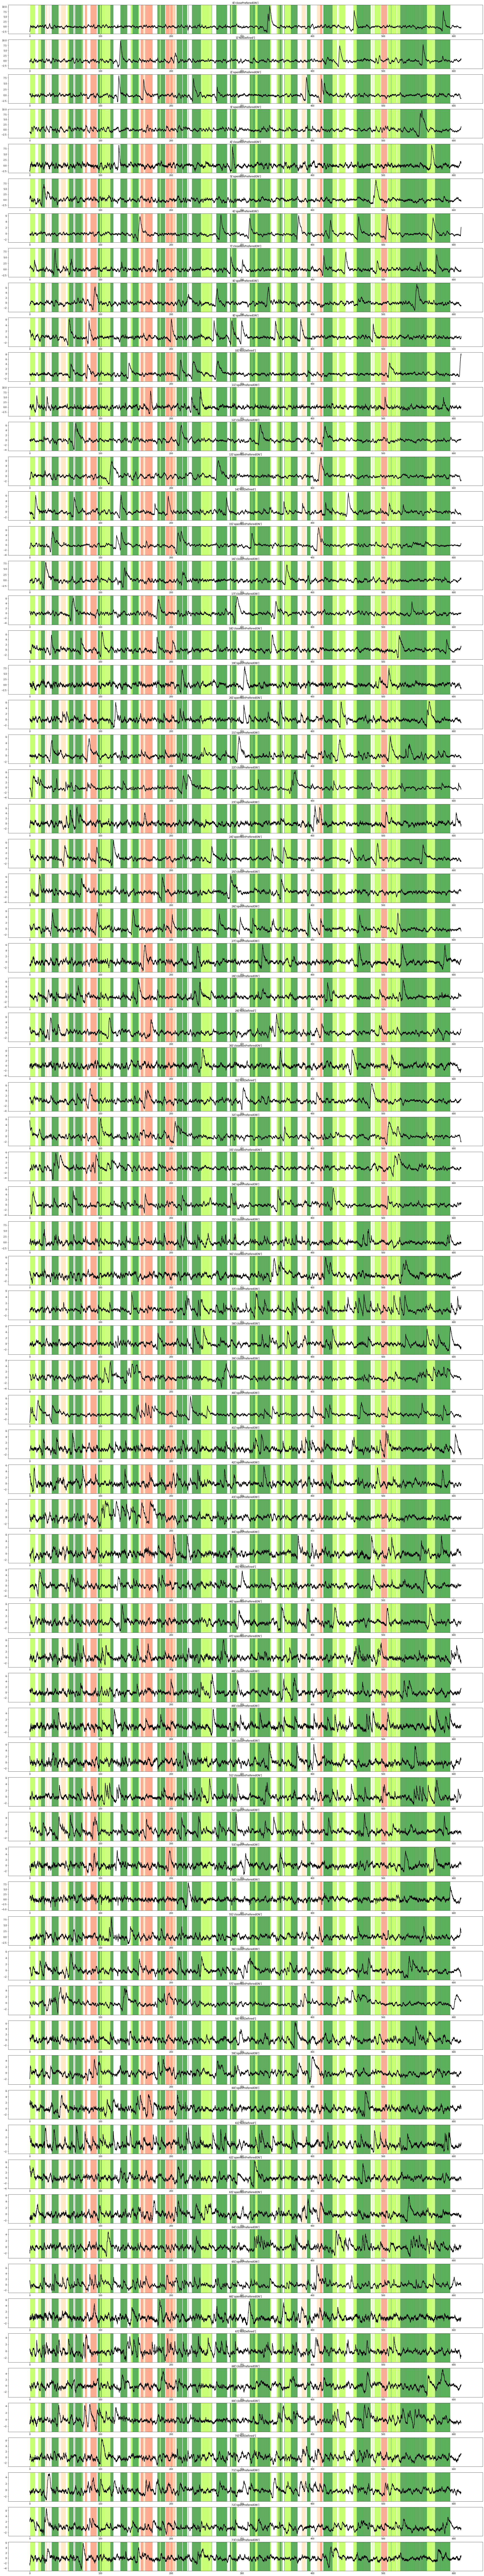

In [42]:
print(' ')
print('ALL. NC314_WT. Find the best F4')
#--------------------------------------------------------------------------------

neuron_no = df.shape[1]
x = df.index.values.tolist()

fig, ax = plt.subplots(neuron_no,1, figsize=(40,3*neuron_no),facecolor='w', edgecolor='k')

for i in range(neuron_no):
    neuron_name = neuron_list[i]
    neuron_type = str(get_neuron_type(neuron_name, keep_on_neurons_1 ,On_Status_1, keep_on_neurons_2, On_Status_2,
                                     keep_on_neurons_3, On_Status_3, keep_on_neurons_4, On_Status_4))
    
    y = df.iloc[:,i].values.tolist()
    
    ax[i].plot(x,y, lw=2, color = 'black')
    ax[i].set_title(str(i)+neuron_type)
    for openP_interval in openP_interval_list:
        ax[i].axvspan(x[openP_interval[0]], x[openP_interval[1]], alpha=0.2, color = 'coral')
    for openNP_interval in openNP_interval_list:
        ax[i].axvspan(x[openNP_interval[0]], x[openNP_interval[1]], alpha=0.2, color = 'navajowhite')
    for closeP_interval in closeP_interval_list:
        ax[i].axvspan(x[closeP_interval[0]], x[closeP_interval[1]], alpha=0.2, color = 'green')
    for closeNP_interval in closeNP_interval_list:
        ax[i].axvspan(x[closeNP_interval[0]], x[closeNP_interval[1]], alpha=0.2, color = 'greenyellow')
        
    
fig.savefig('NC314_df_all_neuron_trace.png')

# Plot Trace

###  Found NC314_WT: 
- openP(coral) - 11
- openNP(lightorange) - 2
- closeP(green) - 12
- closeNP(greenyellow) - 4
- Any - 14
- No - 61

###  Found NC315_WT: 
- openP(coral) - 10
- openNP(lightorange) - 21
- closeP(green) - 6
- closeNP(greenyellow) - 24
- Any - 7
- No - 28

###  Found NC296_NULL: 
- openP(coral) - 11
- openNP(lightorange) - 33
- closeP(green) - 15
- closeNP(greenyellow) - 6
- Any - 4
- No - 3

###  Found NC303_NULL: 
- openP(coral) - 31
- openNP(lightorange) - 2
- closeP(green) - 34
- closeNP(greenyellow) - 7
- Any - 10
- No - 1

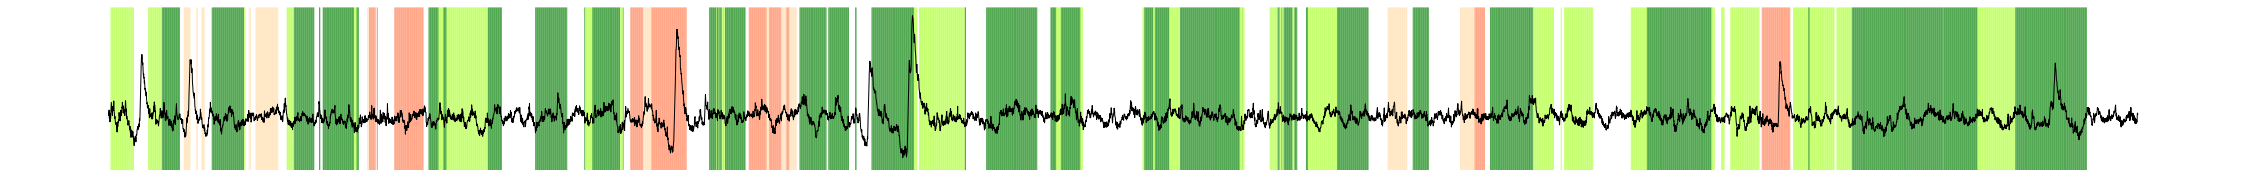

In [43]:
plt.figure(figsize = (40,3))

# x will be for each trace, same frame x-axis
x = df.index.values.tolist()

y_corner = df.iloc[:,11].values.tolist()

plt.plot(x,y_corner, lw=1, color='black')

for openP_interval in openP_interval_list:
    plt.axvspan(x[openP_interval[0]], x[openP_interval[1]], alpha=0.2, color = 'coral')
for openNP_interval in openNP_interval_list:
    plt.axvspan(x[openNP_interval[0]], x[openNP_interval[1]], alpha=0.2, color = 'navajowhite')
for closeP_interval in closeP_interval_list:
    plt.axvspan(x[closeP_interval[0]], x[closeP_interval[1]], alpha=0.2, color = 'green')
for closeNP_interval in closeNP_interval_list:
    plt.axvspan(x[closeNP_interval[0]], x[closeNP_interval[1]], alpha=0.2, color = 'greenyellow')
    
plt.ylim(ymin-0.1, ymax+0.1)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().axes.get_xaxis().set_visible(False)
plt.gca().axes.get_yaxis().set_visible(False)
#plt.gca().spines['top'].set_visible(False)

plt.savefig(mouse_name + '_openP_Trace' + '.png')

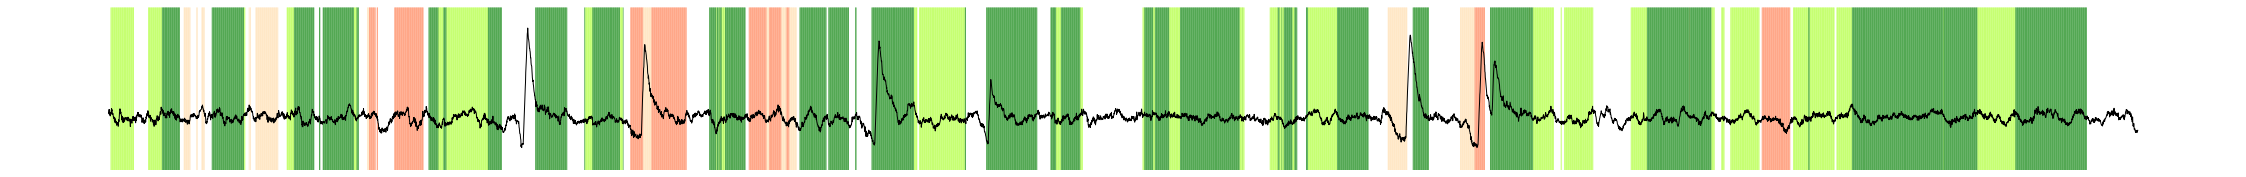

In [44]:
plt.figure(figsize = (40,3))

# x will be for each trace, same frame x-axis
x = df.index.values.tolist()

y_corner = df.iloc[:,2].values.tolist()

plt.plot(x,y_corner, lw=1, color='black')
for openP_interval in openP_interval_list:
    plt.axvspan(x[openP_interval[0]], x[openP_interval[1]], alpha=0.2, color = 'coral')
for openNP_interval in openNP_interval_list:
    plt.axvspan(x[openNP_interval[0]], x[openNP_interval[1]], alpha=0.2, color = 'navajowhite')
for closeP_interval in closeP_interval_list:
    plt.axvspan(x[closeP_interval[0]], x[closeP_interval[1]], alpha=0.2, color = 'green')
for closeNP_interval in closeNP_interval_list:
    plt.axvspan(x[closeNP_interval[0]], x[closeNP_interval[1]], alpha=0.2, color = 'greenyellow')

    
plt.ylim(ymin-0.1, ymax+0.1)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().axes.get_xaxis().set_visible(False)
plt.gca().axes.get_yaxis().set_visible(False)
#plt.gca().spines['top'].set_visible(False)

plt.savefig(mouse_name + '_openNP_Trace' + '.png')

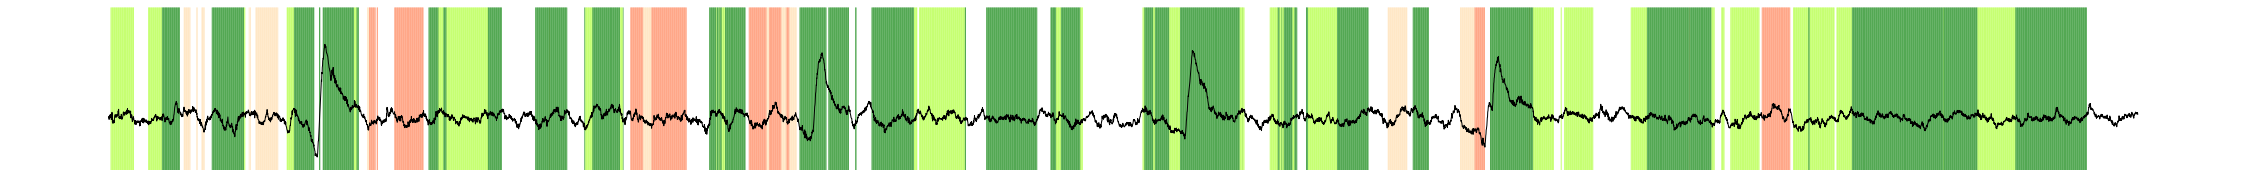

In [45]:
plt.figure(figsize = (40,3))

# x will be for each trace, same frame x-axis
x = df.index.values.tolist()

y_corner = df.iloc[:,12].values.tolist()

plt.plot(x,y_corner, lw=1, color='black')
for openP_interval in openP_interval_list:
    plt.axvspan(x[openP_interval[0]], x[openP_interval[1]], alpha=0.2, color = 'coral')
for openNP_interval in openNP_interval_list:
    plt.axvspan(x[openNP_interval[0]], x[openNP_interval[1]], alpha=0.2, color = 'navajowhite')
for closeP_interval in closeP_interval_list:
    plt.axvspan(x[closeP_interval[0]], x[closeP_interval[1]], alpha=0.2, color = 'green')
for closeNP_interval in closeNP_interval_list:
    plt.axvspan(x[closeNP_interval[0]], x[closeNP_interval[1]], alpha=0.2, color = 'greenyellow')
    
plt.ylim(ymin-0.1, ymax+0.1)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().axes.get_xaxis().set_visible(False)
plt.gca().axes.get_yaxis().set_visible(False)
#plt.gca().spines['top'].set_visible(False)

plt.savefig(mouse_name + '_closeP_Trace' + '.png')

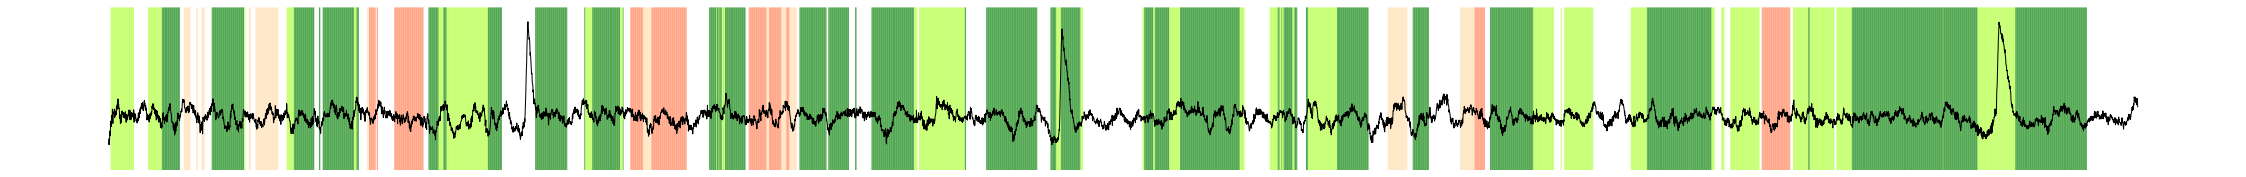

In [46]:
plt.figure(figsize = (40,3))

# x will be for each trace, same frame x-axis
x = df.index.values.tolist()

y_corner = df.iloc[:,4].values.tolist()

plt.plot(x,y_corner, lw=1, color='black')
for openP_interval in openP_interval_list:
    plt.axvspan(x[openP_interval[0]], x[openP_interval[1]], alpha=0.2, color = 'coral')
for openNP_interval in openNP_interval_list:
    plt.axvspan(x[openNP_interval[0]], x[openNP_interval[1]], alpha=0.2, color = 'navajowhite')
for closeP_interval in closeP_interval_list:
    plt.axvspan(x[closeP_interval[0]], x[closeP_interval[1]], alpha=0.2, color = 'green')
for closeNP_interval in closeNP_interval_list:
    plt.axvspan(x[closeNP_interval[0]], x[closeNP_interval[1]], alpha=0.2, color = 'greenyellow')

    
plt.ylim(ymin-0.1, ymax+0.1)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().axes.get_xaxis().set_visible(False)
plt.gca().axes.get_yaxis().set_visible(False)
#plt.gca().spines['top'].set_visible(False)

plt.savefig(mouse_name + '_closeNP_Trace' + '.png')

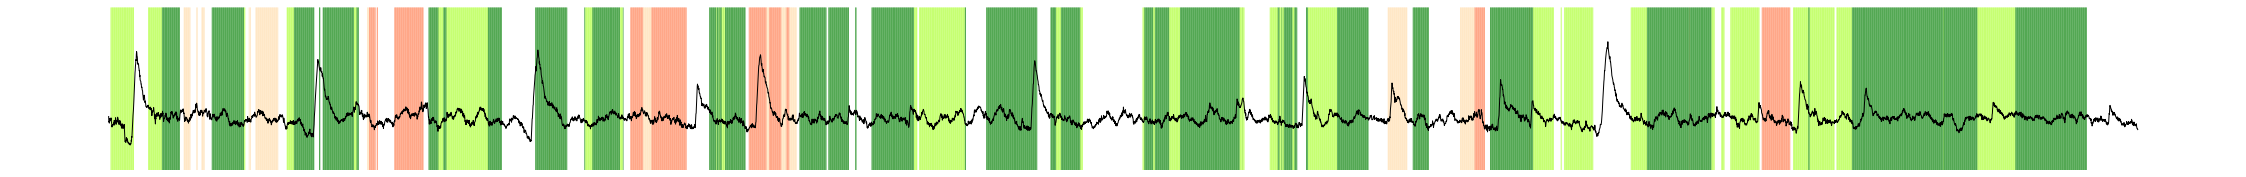

In [47]:
plt.figure(figsize = (40,3))

# x will be for each trace, same frame x-axis
x = df.index.values.tolist()

y_corner = df.iloc[:,14].values.tolist()

plt.plot(x,y_corner, lw=1, color='black')
for openP_interval in openP_interval_list:
    plt.axvspan(x[openP_interval[0]], x[openP_interval[1]], alpha=0.2, color = 'coral')
for openNP_interval in openNP_interval_list:
    plt.axvspan(x[openNP_interval[0]], x[openNP_interval[1]], alpha=0.2, color = 'navajowhite')
for closeP_interval in closeP_interval_list:
    plt.axvspan(x[closeP_interval[0]], x[closeP_interval[1]], alpha=0.2, color = 'green')
for closeNP_interval in closeNP_interval_list:
    plt.axvspan(x[closeNP_interval[0]], x[closeNP_interval[1]], alpha=0.2, color = 'greenyellow')

    
plt.ylim(ymin-0.1, ymax+0.1)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().axes.get_xaxis().set_visible(False)
plt.gca().axes.get_yaxis().set_visible(False)
#plt.gca().spines['top'].set_visible(False)

plt.savefig(mouse_name + '_FireAny_Trace' + '.png')

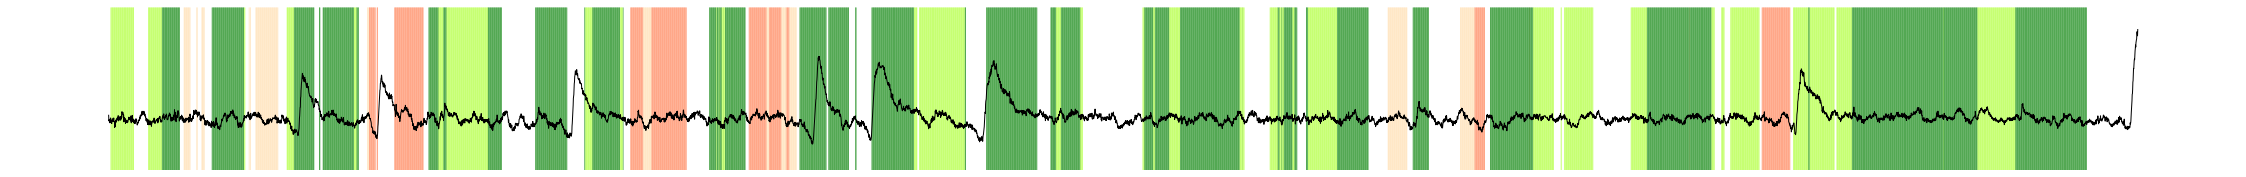

In [49]:
plt.figure(figsize = (40,3))

# x will be for each trace, same frame x-axis
x = df.index.values.tolist()

y_corner = df.iloc[:,10].values.tolist()

plt.plot(x,y_corner, lw=1, color='black')
for openP_interval in openP_interval_list:
    plt.axvspan(x[openP_interval[0]], x[openP_interval[1]], alpha=0.2, color = 'coral')
for openNP_interval in openNP_interval_list:
    plt.axvspan(x[openNP_interval[0]], x[openNP_interval[1]], alpha=0.2, color = 'navajowhite')
for closeP_interval in closeP_interval_list:
    plt.axvspan(x[closeP_interval[0]], x[closeP_interval[1]], alpha=0.2, color = 'green')
for closeNP_interval in closeNP_interval_list:
    plt.axvspan(x[closeNP_interval[0]], x[closeNP_interval[1]], alpha=0.2, color = 'greenyellow')

    
plt.ylim(ymin-0.1, ymax+0.1)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().axes.get_xaxis().set_visible(False)
plt.gca().axes.get_yaxis().set_visible(False)
#plt.gca().spines['top'].set_visible(False)

plt.savefig(mouse_name + '_NoAny_Trace' + '.png')

# Average Spatial Activity Map

- ASAM for each neuron
- total activity in a specific x-y location / total time the animal spent in that location
- x-y data were discretized in 256 pixels & smoothed with a 2D guassian kernel that was 1/64 the arena size

Get Average Spatial Activity Map And Plot
65 neurons are not correct
59 neurons are not our target
103 neurons are removing
 
The df shape of trace df with label: (11800, 78)


/Users/xiaoqiansun/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/xiaoqiansun/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/xiaoqiansun/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

neuron_index:  0
xmin: 301.0  xmax: 679.0  ymin: 95.0  ymax: 641.0  zmin: -0.4065484680519481  zmax: 0.5185176128571427
img_array shape:  (380, 549)
smoothed z min -1.4065484680519487 smoothed z max -0.01808157145765816
--------------------------------------------


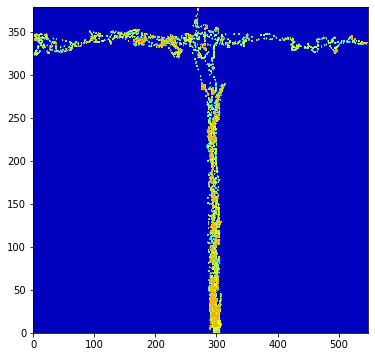

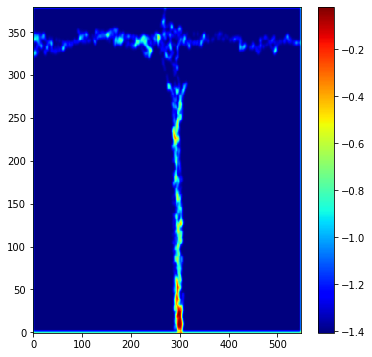

In [62]:
print('Get Average Spatial Activity Map And Plot')

for i in range(len(WT_list)):
    
    mouse_name = WT_list[i]
    
    if mouse_name.split('_')[0] in ['NC128','NC102', 'NC013']:
        fps = 20
    else:
        fps = 15
    
    mice = os.path.join(root_path, mouse_name)
    trace = os.path.join(root_path, mouse_name, "trace.csv")
    position = os.path.join(root_path, mouse_name, "cells position.csv")
    event = os.path.join(root_path, mouse_name, "events.xlsx")
    incorrect = os.path.join(root_path_incorrect, WT_incorrect_neuron_list[i])
    coordinate = os.path.join(root_path, mouse_name,'{}.TXT'.format(mouse_name.split('_')[0]))

    # process trace file
    df = process_(trace, incorrect, position)
    df_frame_label = add_event_label(df, event, mice)

    # get Average Spatial Activity Map csv file
    df_norm_act = ASAM(df_frame_label, coordinate, mouse_name, fps)

    # get all neuron avg activity
    df_norm_act_all = pd.DataFrame()
    df_norm_act_all['all_neuron_avg'] = df_norm_act.iloc[:, :-2].mean(axis = 1)
    df_norm_act_all['X'] = df_norm_act['X'].values.tolist()
    df_norm_act_all['Y'] = df_norm_act['Y'].values.tolist()

    AllNeuron_img_array, AllNeuron_img_array_sm = img_array(df_norm_act_all, neuron_index = 0, 
                                                            sigma_x = 2.0, sigma_y = 2.0, PAD=False, padder = None)

    # plot
    # original location
    plt.figure(figsize = (6,6))
    camp = 'jet'
    fig = plt.contourf(AllNeuron_img_array,  cmap=camp)
    plt.savefig(mouse_name +'_AllNeuron.png')

    # smoothed location
    plt.figure(figsize = (6,6))
    plt.imshow(AllNeuron_img_array_sm, 
               cmap='jet', 
               interpolation='nearest', aspect='auto',
               origin='lower', 
              #vmin=-3, vmax=0
              )
    plt.savefig(mouse_name +'_AllNeuron_Smoothed.png')
    plt.colorbar()

    break

Get Average Spatial Activity Map And Plot
57 neurons are not correct
136 neurons are not our target
141 neurons are removing
 
The df shape of trace df with label: (11800, 40)


/Users/xiaoqiansun/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/xiaoqiansun/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/xiaoqiansun/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

neuron_index:  0
xmin: 300.0  xmax: 954.0  ymin: 89.0  ymax: 684.0  zmin: -0.4555287434358974  zmax: 0.5532937605897437
img_array shape:  (656, 598)
smoothed z min -1.455528743435898 smoothed z max -0.11885478741668666
--------------------------------------------
74 neurons are not correct
139 neurons are not our target
156 neurons are removing
 
The df shape of trace df with label: (11800, 25)
neuron_index:  0
xmin: 328.0  xmax: 970.0  ymin: 129.0  ymax: 641.0  zmin: -0.6581045787499998  zmax: 0.7284003783333333
img_array shape:  (644, 515)
smoothed z min -1.6581045787500004 smoothed z max -0.09680239665462334
--------------------------------------------
47 neurons are not correct
101 neurons are not our target
119 neurons are removing
 
The df shape of trace df with label: (8958, 62)
neuron_index:  0
xmin: 340.0  xmax: 988.0  ymin: 91.0  ymax: 704.0  zmin: -0.3856444485245901  zmax: 0.39316299868852456
img_array shape:  (650, 616)
smoothed z min -1.3856444485245902 smoothed z max -0.

/Users/xiaoqiansun/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/xiaoqiansun/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


96 neurons are not correct
76 neurons are not our target
124 neurons are removing
 
The df shape of trace df with label: (8925, 57)
neuron_index:  0
xmin: 658.0  xmax: 1045.0  ymin: 328.0  ymax: 453.0  zmin: -0.3010839091071428  zmax: 0.5027572134464288
img_array shape:  (389, 128)
smoothed z min -1.3010839091071427 smoothed z max -0.023294737540185975
--------------------------------------------
98 neurons are not correct
120 neurons are not our target
155 neurons are removing
 
The df shape of trace df with label: (8925, 26)
neuron_index:  0
xmin: 357.0  xmax: 1042.0  ymin: 71.0  ymax: 700.0  zmin: -0.9336967960000001  zmax: 0.9121515647999999
img_array shape:  (687, 632)
smoothed z min -1.933696796 smoothed z max -0.2593166967226256
--------------------------------------------
83 neurons are not correct
156 neurons are not our target
171 neurons are removing
 
The df shape of trace df with label: (8925, 10)
neuron_index:  0
xmin: 997.0  xmax: 1047.0  ymin: 377.0  ymax: 395.0  zmin: 

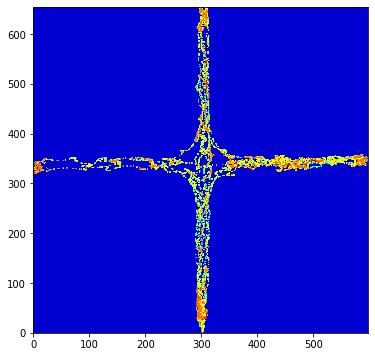

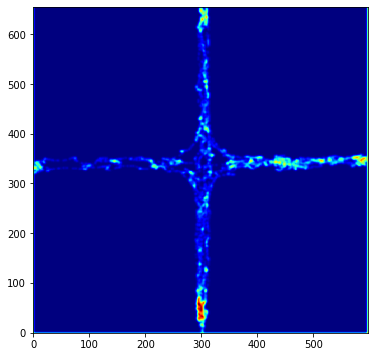

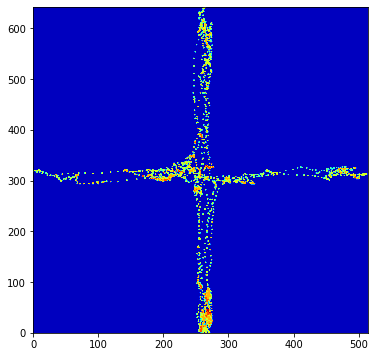

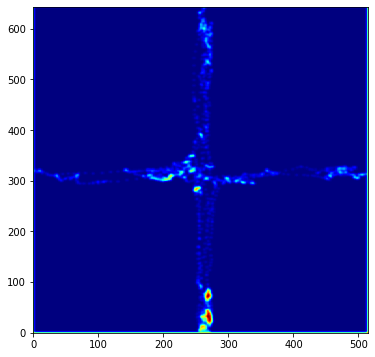

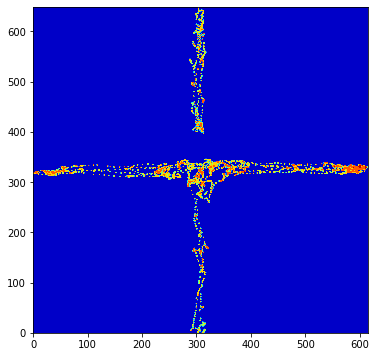

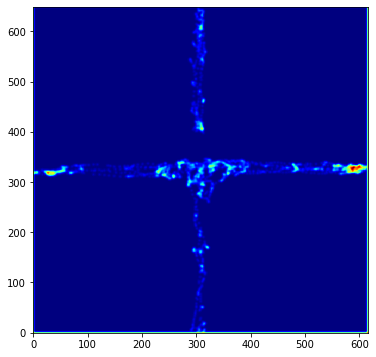

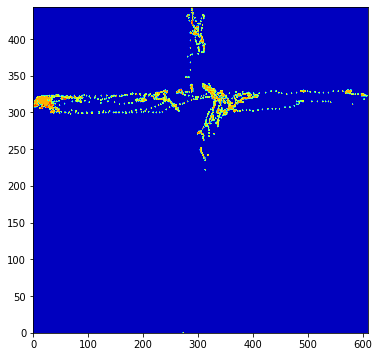

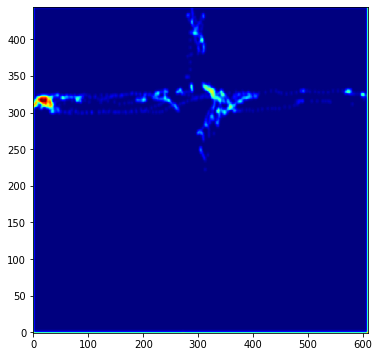

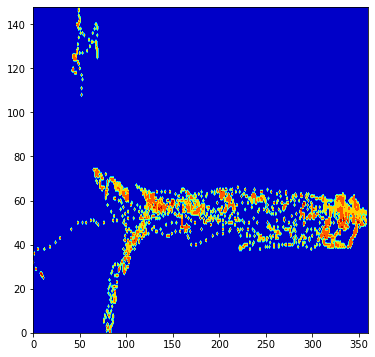

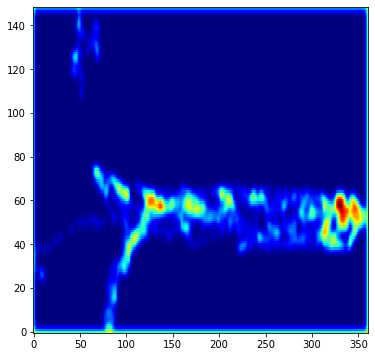

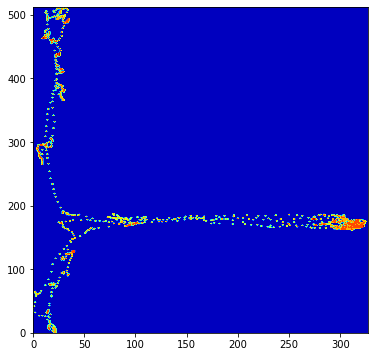

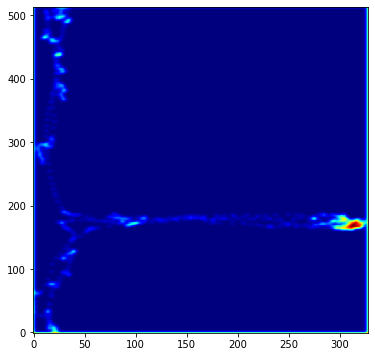

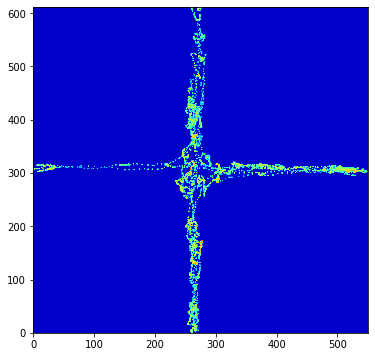

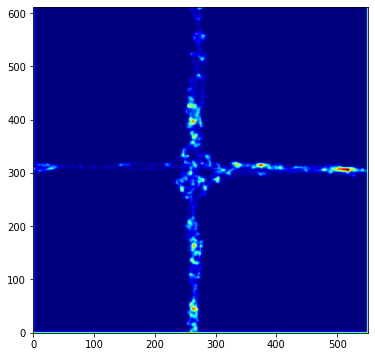

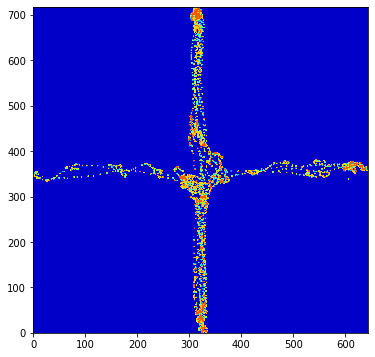

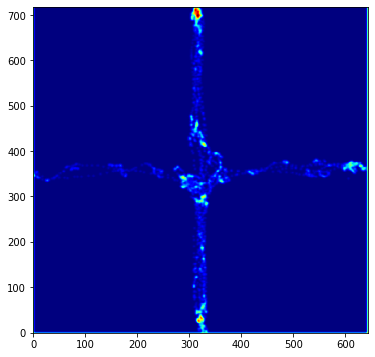

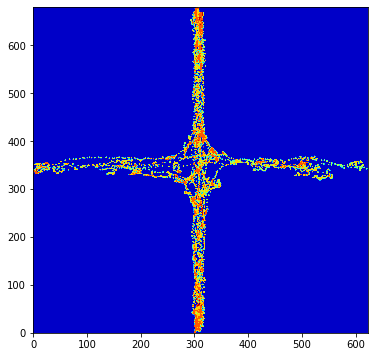

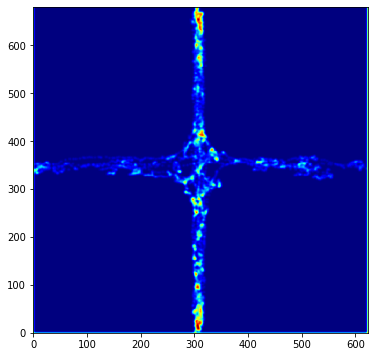

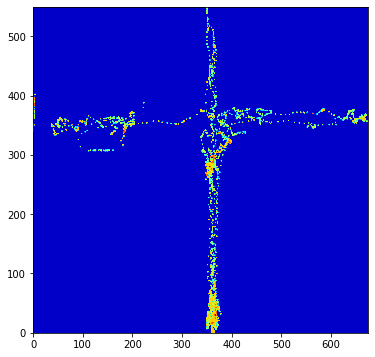

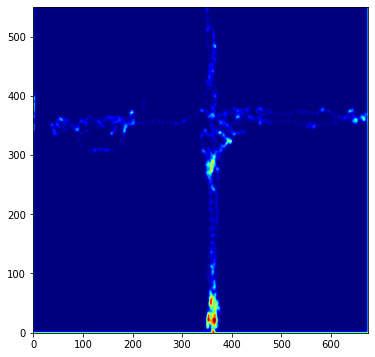

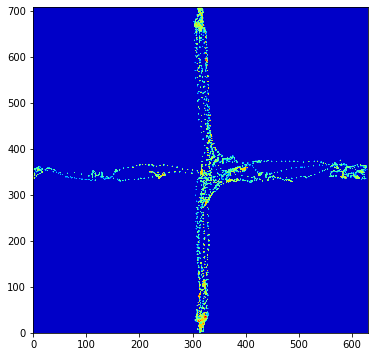

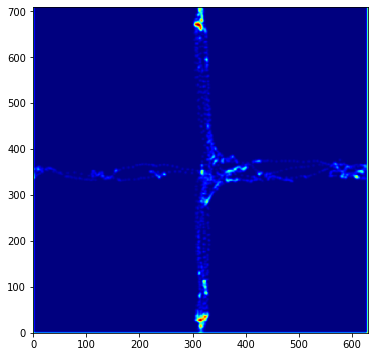

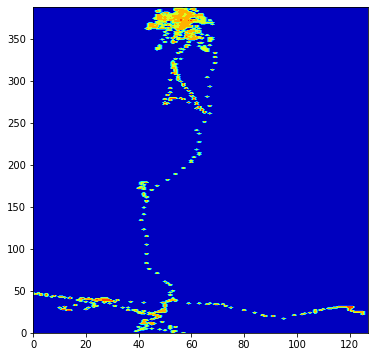

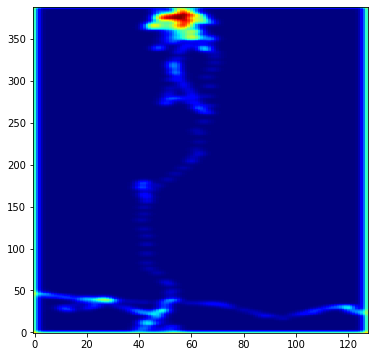

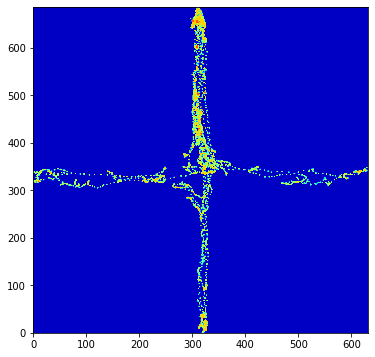

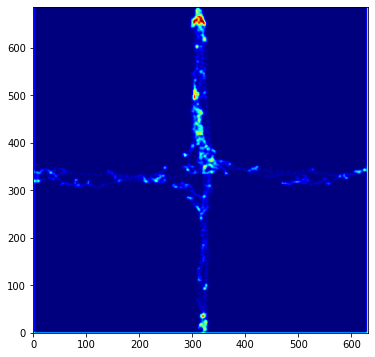

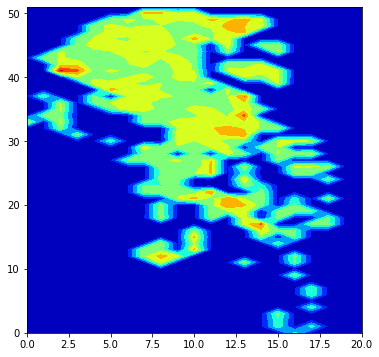

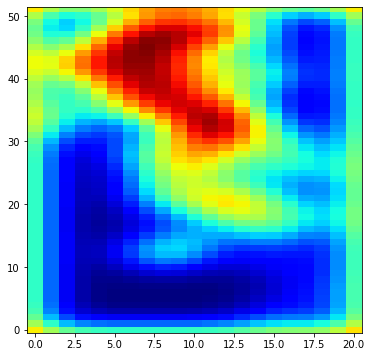

In [61]:
print('Get Average Spatial Activity Map And Plot')

for i in range(len(NULL_list)):
    
    mouse_name = NULL_list[i]
    
    if mouse_name.split('_')[0] in ['NC128','NC102', 'NC013']:
        fps = 20
    else:
        fps = 15
    
    mice = os.path.join(root_path, mouse_name)
    trace = os.path.join(root_path, mouse_name, "trace.csv")
    position = os.path.join(root_path, mouse_name, "cells position.csv")
    event = os.path.join(root_path, mouse_name, "events.xlsx")
    incorrect = os.path.join(root_path_incorrect, NULL_incorrect_neuron_list[i])
    coordinate = os.path.join(root_path, mouse_name,'{}.TXT'.format(mouse_name.split('_')[0]))

    # process trace file
    df = process_(trace, incorrect, position)
    df_frame_label = add_event_label(df, event, mice)

    # get Average Spatial Activity Map csv file
    df_norm_act = ASAM(df_frame_label, coordinate, mouse_name, fps)

    # get all neuron avg activity
    df_norm_act_all = pd.DataFrame()
    df_norm_act_all['all_neuron_avg'] = df_norm_act.iloc[:, :-2].mean(axis = 1)
    df_norm_act_all['X'] = df_norm_act['X'].values.tolist()
    df_norm_act_all['Y'] = df_norm_act['Y'].values.tolist()

    AllNeuron_img_array, AllNeuron_img_array_sm = img_array(df_norm_act_all, neuron_index = 0, 
                                                            sigma_x = 2.0, sigma_y = 2.0, PAD=False, padder = None)

    # plot
    # original location
    plt.figure(figsize = (6,6))
    camp = 'jet'
    fig = plt.contourf(AllNeuron_img_array,  cmap=camp)
    plt.savefig(mouse_name +'_AllNeuron.png')

    # smoothed location
    plt.figure(figsize = (6,6))
    plt.imshow(AllNeuron_img_array_sm, 
               cmap='jet', 
               interpolation='nearest', aspect='auto',
               origin='lower', 
              #vmin=-3, vmax=0
              )
    plt.savefig(mouse_name +'_AllNeuron_Smoothed.png')



# Average Spatial Activity Map
- build bridge by hand:
    - read average spatial activity map, including x,y
    - find biggest x,y
    - build empty bridge
    - plot location on blank bridge

In [86]:
root_path_activity = r'/Users/xiaoqiansun/Desktop/MedLu/EPM/EPM_Data/Average_Spatial_Activity'

X_list = []
Y_list = []
for i in range(len(NULL_list)):
    
    mouse_name = NULL_list[i]
    
    file_name = mouse_name + '_Average_Spatial_Activity.csv'
    
    avg_spatial_activity_df = pd.read_csv(os.path.join(root_path_activity, file_name))
    x_max = avg_spatial_activity_df.max()[-2]
    x_min = avg_spatial_activity_df.min()[-2]
    y_max = avg_spatial_activity_df.max()[-1]
    y_min = avg_spatial_activity_df.min()[-1]
    X_list.append(x_max)
    X_list.append(x_min)
    Y_list.append(y_max)
    Y_list.append(y_min)

X_Max = max(X_list)
X_Min = min(X_list)

Y_Max = max(Y_list)
Y_Min = min(Y_list)

print(X_Max-X_Min)
print(Y_Max-Y_Min)

''' Empty image should be 800*800 or 750*750 '''

747.0
682.0


' Empty image should be 800*800 or 750*750'

Get Average Spatial Activity Map And Plot
neuron_index:  0
xmin: 301.0  xmax: 679.0  ymin: 95.0  ymax: 641.0  zmin: -0.4065484680519481  zmax: 0.5185176128571427
img_array shape:  (750, 750)
smoothed z min -1.4065484680519487 smoothed z max -0.018081571457658166
--------------------------------------------
neuron_index:  0
xmin: 576.0  xmax: 751.0  ymin: 94.0  ymax: 699.0  zmin: -0.30278515662337663  zmax: 0.38044407376623374
img_array shape:  (750, 750)
smoothed z min -1.3027851566233766 smoothed z max -0.06741554406437494
--------------------------------------------
neuron_index:  0
xmin: 301.0  xmax: 807.0  ymin: 380.0  ymax: 707.0  zmin: -0.3218062578614458  zmax: 0.2907113285542169
img_array shape:  (750, 750)
smoothed z min -1.321806257861446 smoothed z max -0.196749608098401
--------------------------------------------
neuron_index:  0
xmin: 658.0  xmax: 843.0  ymin: 367.0  ymax: 697.0  zmin: -1.055552627142857  zmax: 1.395970414285714
img_array shape:  (750, 750)
smoothed z min

/Users/xiaoqiansun/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/xiaoqiansun/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


neuron_index:  0
xmin: 352.0  xmax: 1036.0  ymin: 27.0  ymax: 588.0  zmin: -0.5118519272000001  zmax: 0.5115935262
img_array shape:  (750, 750)
smoothed z min -1.5118519272000004 smoothed z max -0.03562845952812102
--------------------------------------------
neuron_index:  0
xmin: 337.0  xmax: 1035.0  ymin: 334.0  ymax: 463.0  zmin: -0.2949958319021739  zmax: 0.35692217858695646
img_array shape:  (750, 750)
smoothed z min -1.294995831902174 smoothed z max -0.11191577407977493
--------------------------------------------
neuron_index:  0
xmin: 324.0  xmax: 1003.0  ymin: 75.0  ymax: 613.0  zmin: -0.5526055925  zmax: 0.9411095425
img_array shape:  (750, 750)
smoothed z min -1.5526055925 smoothed z max -0.10270419063511958
--------------------------------------------
neuron_index:  0
xmin: 330.0  xmax: 715.0  ymin: 362.0  ymax: 479.0  zmin: -0.7606362230769231  zmax: 1.1872733846153847
img_array shape:  (750, 750)
smoothed z min -1.760636223076923 smoothed z max -0.20656770570371905
-----

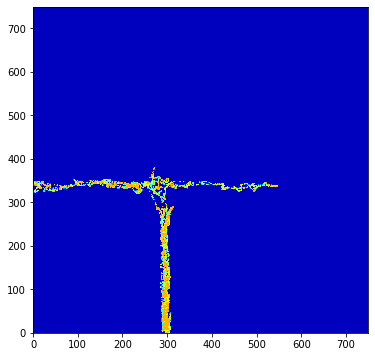

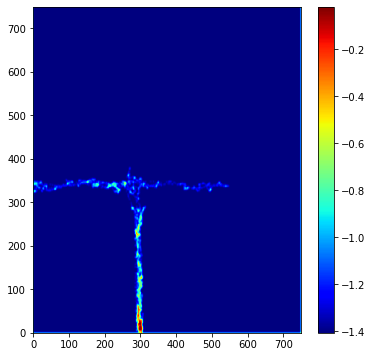

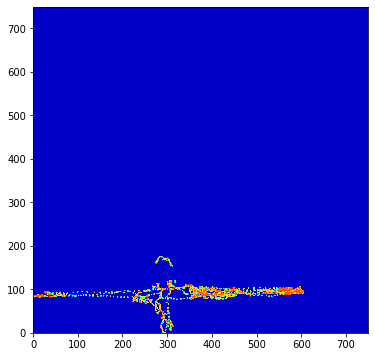

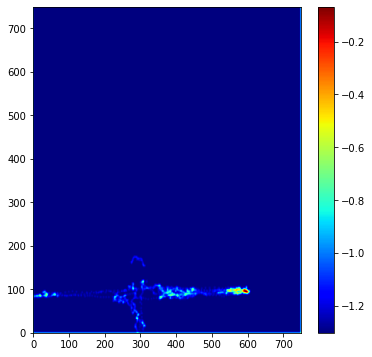

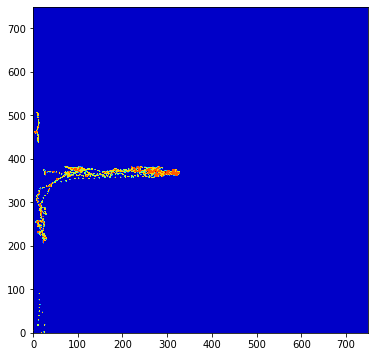

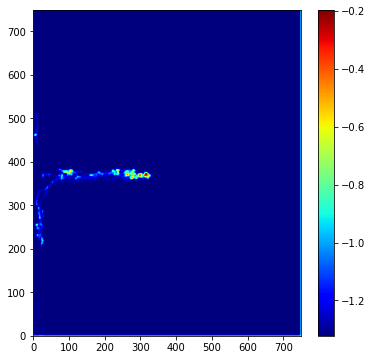

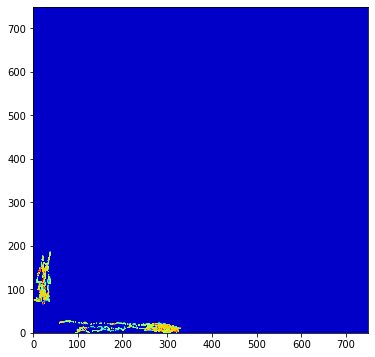

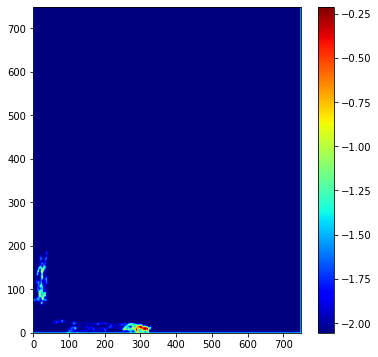

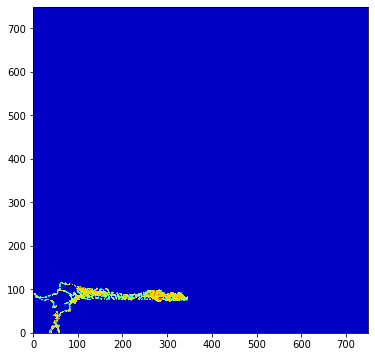

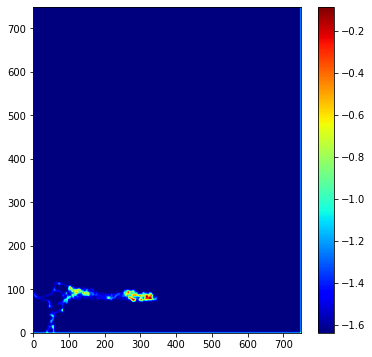

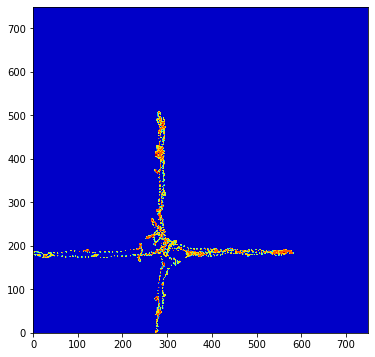

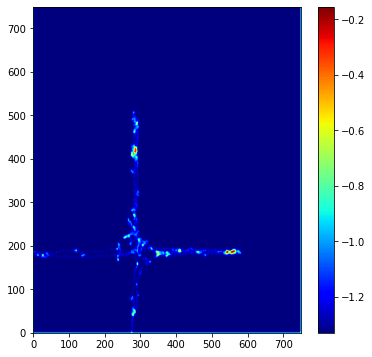

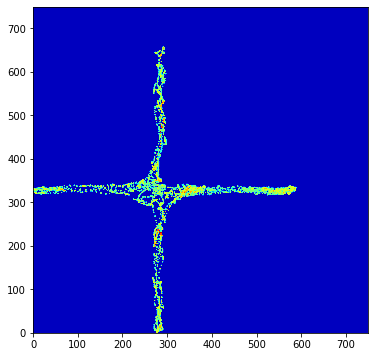

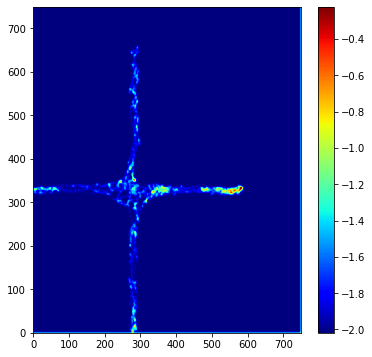

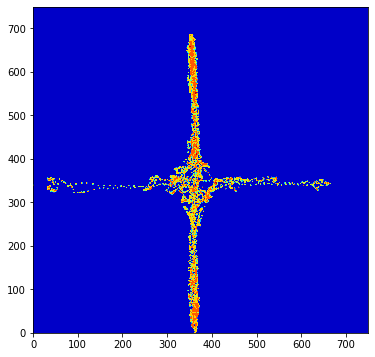

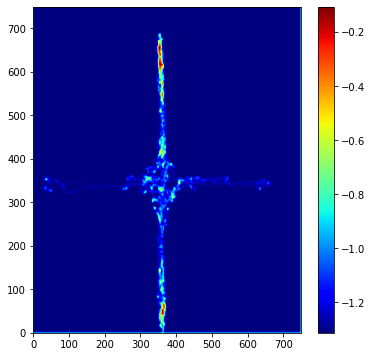

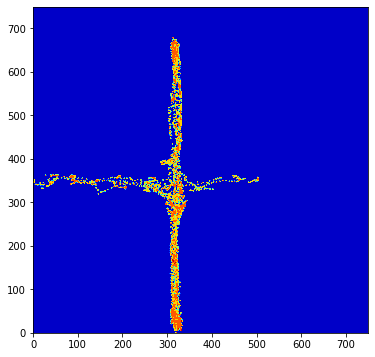

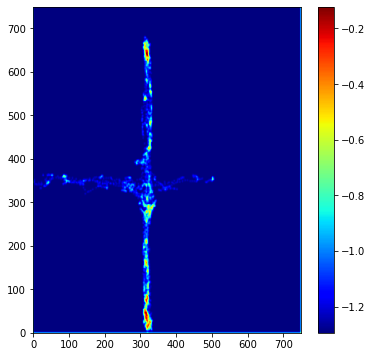

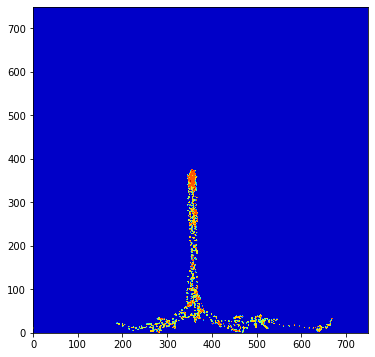

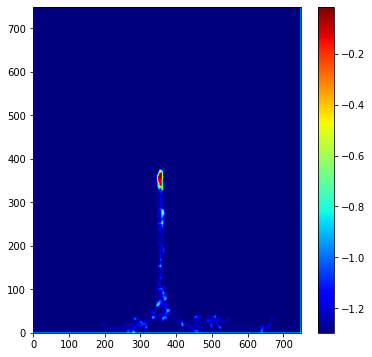

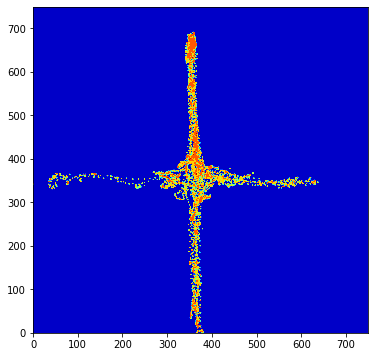

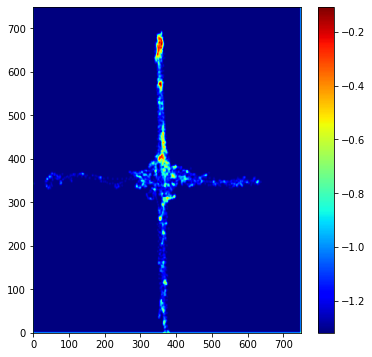

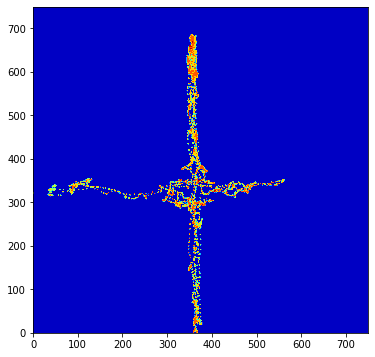

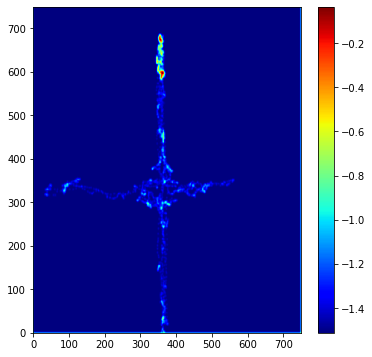

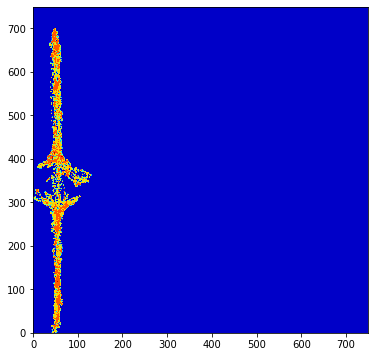

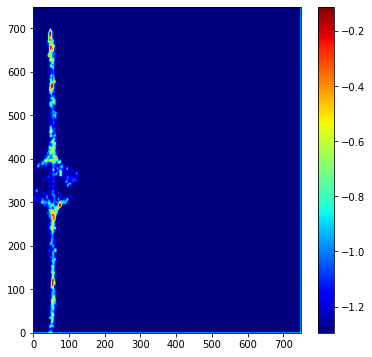

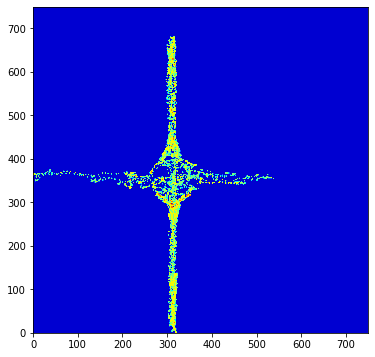

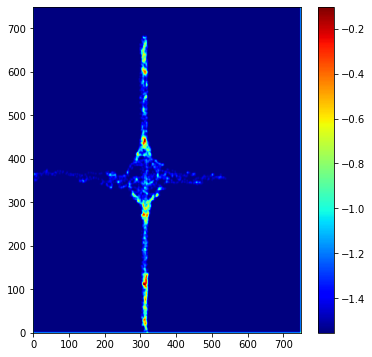

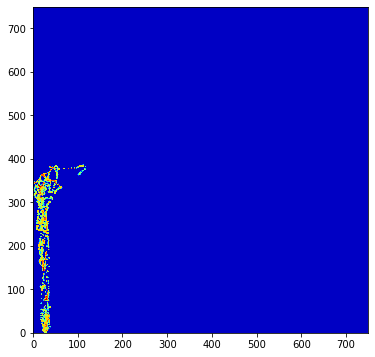

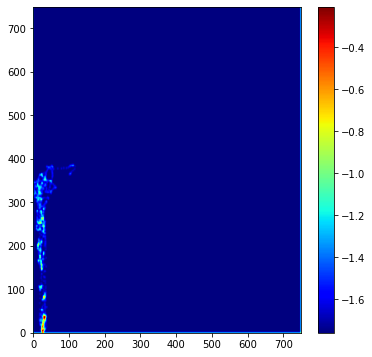

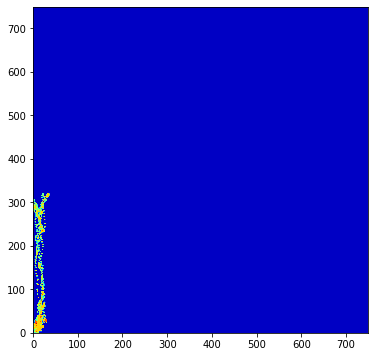

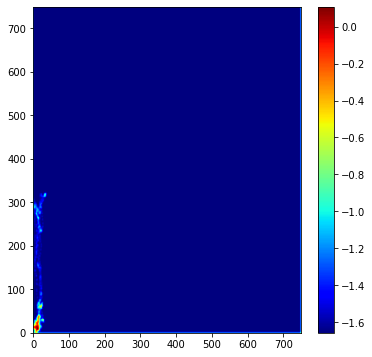

In [92]:
print('WT ALL Get Average Spatial Activity Map And Plot')

for i in range(len(WT_list)):
    
    mouse_name = WT_list[i]
    
    if mouse_name.split('_')[0] in ['NC128','NC102', 'NC013']:
        fps = 20
    else:
        fps = 15
    
    file_name = mouse_name + '_Average_Spatial_Activity.csv'
    
    df_norm_act = pd.read_csv(os.path.join(root_path_activity, file_name))

    # get all neuron avg activity
    df_norm_act_all = pd.DataFrame()
    df_norm_act_all['all_neuron_avg'] = df_norm_act.iloc[:, :-2].mean(axis = 1)
    df_norm_act_all['X'] = df_norm_act['X'].values.tolist()
    df_norm_act_all['Y'] = df_norm_act['Y'].values.tolist()

    AllNeuron_img_array, AllNeuron_img_array_sm = img_array(df_norm_act_all, neuron_index = 0,
                                                            sigma_x = 2.0, sigma_y = 2.0, PAD=False, padder = None,
                                                            shape = (750, 750))

    # plot
    # original location
    plt.figure(figsize = (6,6))
    camp = 'jet'
    fig = plt.contourf(AllNeuron_img_array,  cmap=camp)
    plt.savefig(mouse_name +'_AllNeuron.png')

    # smoothed location
    plt.figure(figsize = (6,6))
    plt.imshow(AllNeuron_img_array_sm, 
               cmap='jet', 
               interpolation='nearest', aspect='auto',
               origin='lower', 
              #vmin=-3, vmax=0
              )
    plt.savefig(mouse_name +'_AllNeuron_Smoothed.png')
    plt.colorbar()

Get Average Spatial Activity Map And Plot
neuron_index:  0
xmin: 300.0  xmax: 954.0  ymin: 89.0  ymax: 684.0  zmin: -0.4555287434358974  zmax: 0.5532937605897437
img_array shape:  (750, 750)
smoothed z min -1.455528743435898 smoothed z max -0.11885478741668666
--------------------------------------------
neuron_index:  0
xmin: 328.0  xmax: 970.0  ymin: 129.0  ymax: 641.0  zmin: -0.6581045787499998  zmax: 0.7284003783333333
img_array shape:  (750, 750)
smoothed z min -1.6581045787500004 smoothed z max -0.09680239665462335
--------------------------------------------
neuron_index:  0
xmin: 340.0  xmax: 988.0  ymin: 91.0  ymax: 704.0  zmin: -0.3856444485245901  zmax: 0.39316299868852456
img_array shape:  (750, 750)
smoothed z min -1.3856444485245902 smoothed z max -0.16207404858196262
--------------------------------------------
neuron_index:  0
xmin: 350.0  xmax: 793.0  ymin: 93.0  ymax: 700.0  zmin: -0.28283640232876706  zmax: 0.5647103508219178
img_array shape:  (750, 750)
smoothed z m

/Users/xiaoqiansun/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/xiaoqiansun/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


neuron_index:  0
xmin: 658.0  xmax: 1045.0  ymin: 328.0  ymax: 453.0  zmin: -0.3010839091071428  zmax: 0.5027572134464287
img_array shape:  (750, 750)
smoothed z min -1.3010839091071427 smoothed z max -0.023294737540185975
--------------------------------------------
neuron_index:  0
xmin: 357.0  xmax: 1042.0  ymin: 71.0  ymax: 700.0  zmin: -0.9336967960000001  zmax: 0.9121515647999999
img_array shape:  (750, 750)
smoothed z min -1.933696796 smoothed z max -0.2593166967226256
--------------------------------------------
neuron_index:  0
xmin: 997.0  xmax: 1047.0  ymin: 377.0  ymax: 395.0  zmin: -0.6934163488888889  zmax: 1.2652904379629628
img_array shape:  (750, 750)
smoothed z min -1.693416348888889 smoothed z max -0.038836063316612164
--------------------------------------------


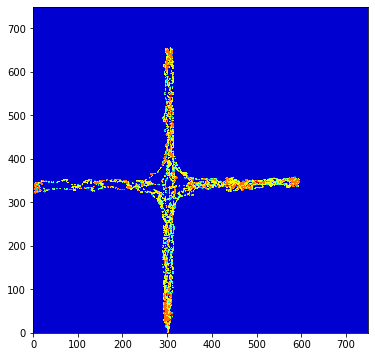

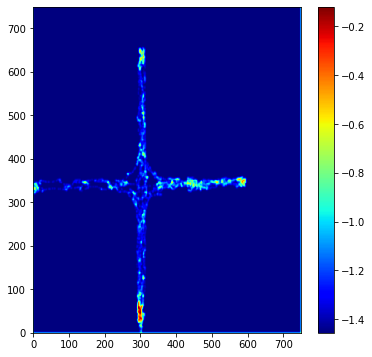

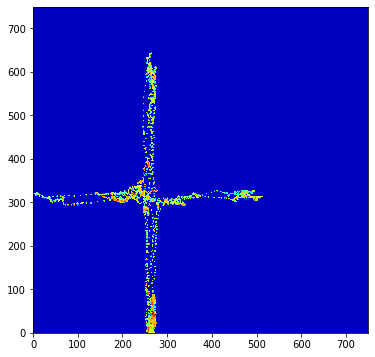

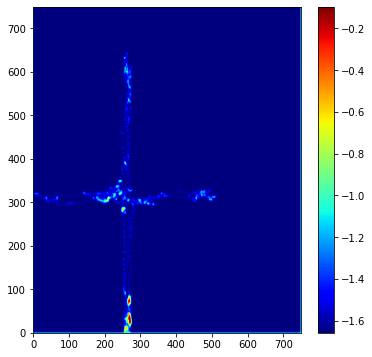

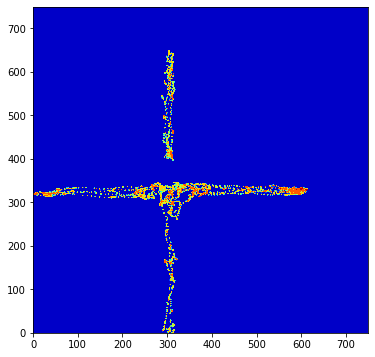

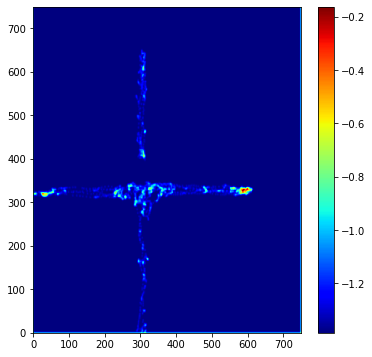

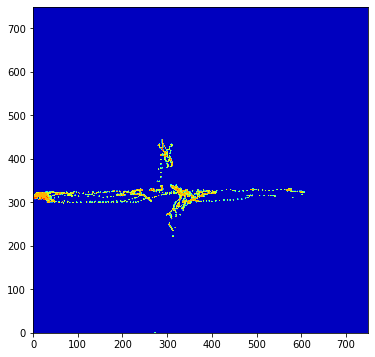

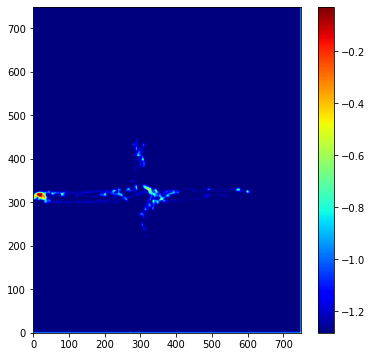

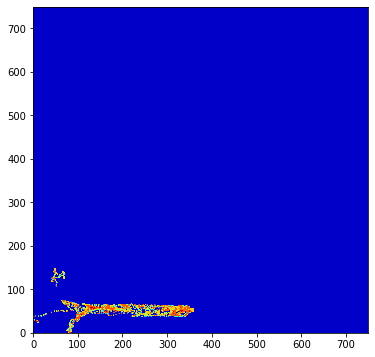

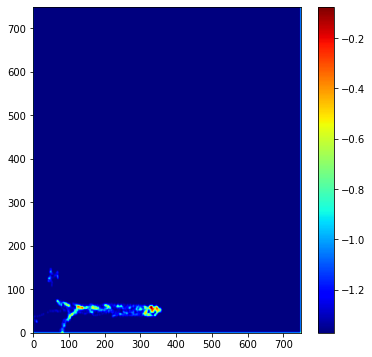

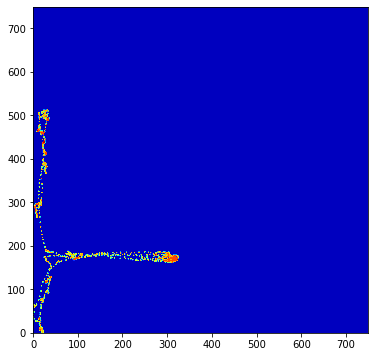

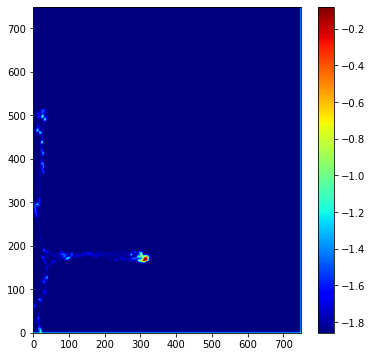

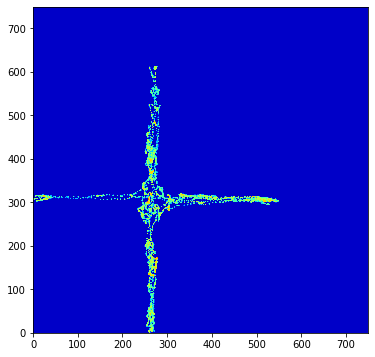

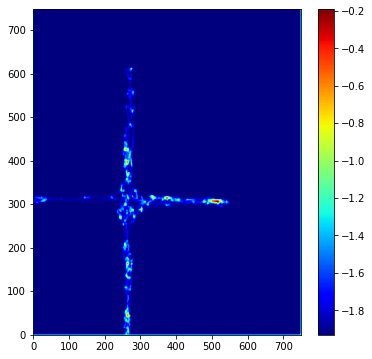

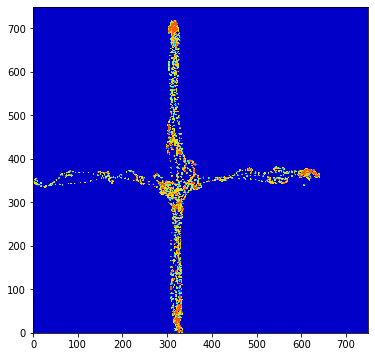

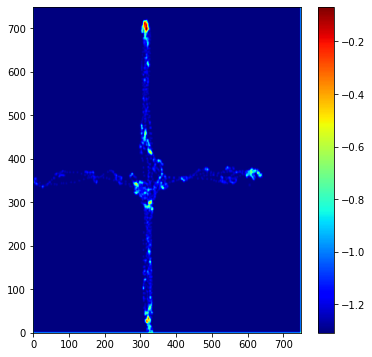

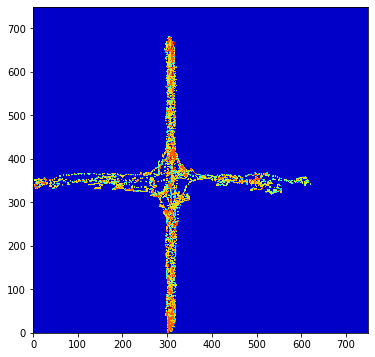

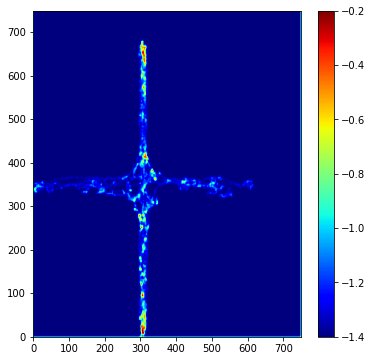

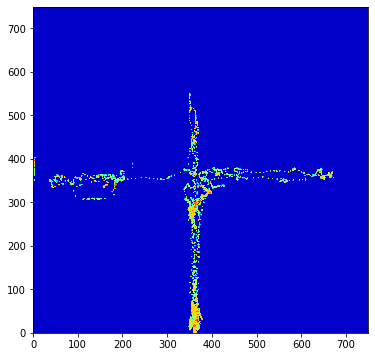

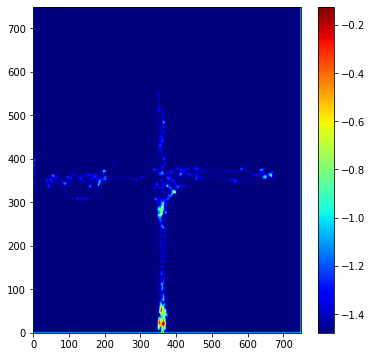

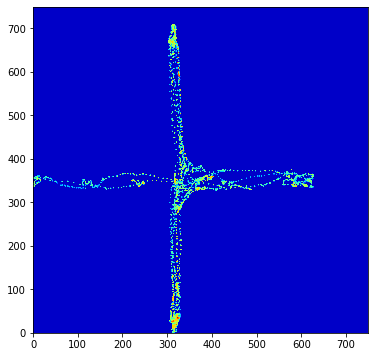

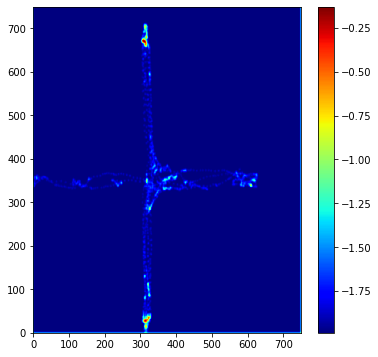

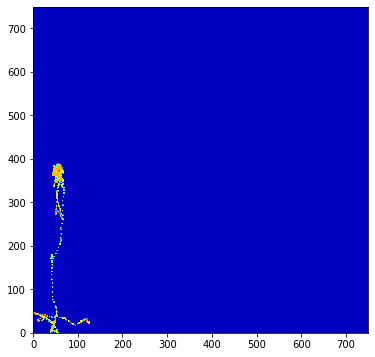

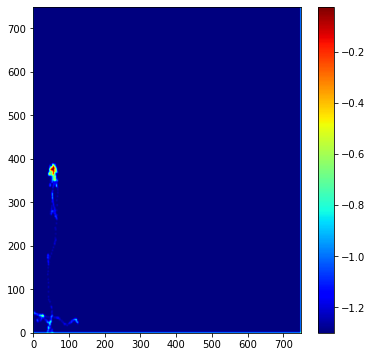

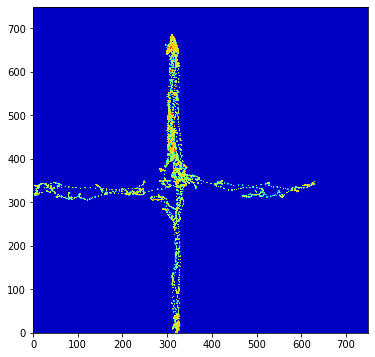

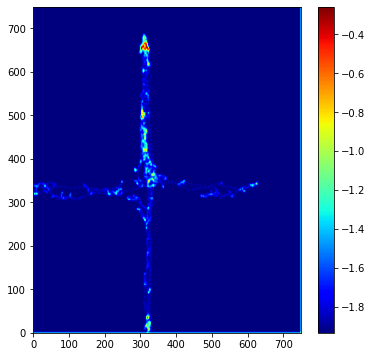

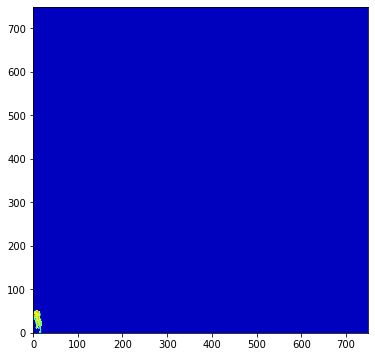

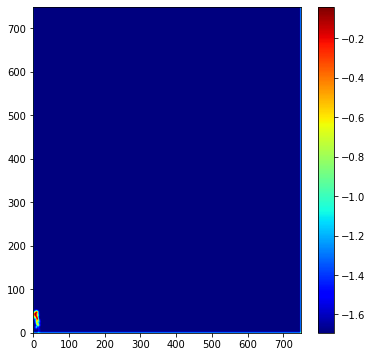

In [93]:
print('NUL ALL Get Average Spatial Activity Map And Plot')

for i in range(len(NULL_list)):
    
    mouse_name = NULL_list[i]
    
    if mouse_name.split('_')[0] in ['NC128','NC102', 'NC013']:
        fps = 20
    else:
        fps = 15
    
    file_name = mouse_name + '_Average_Spatial_Activity.csv'
    
    df_norm_act = pd.read_csv(os.path.join(root_path_activity, file_name))

    # get all neuron avg activity
    df_norm_act_all = pd.DataFrame()
    df_norm_act_all['all_neuron_avg'] = df_norm_act.iloc[:, :-2].mean(axis = 1)
    df_norm_act_all['X'] = df_norm_act['X'].values.tolist()
    df_norm_act_all['Y'] = df_norm_act['Y'].values.tolist()

    AllNeuron_img_array, AllNeuron_img_array_sm = img_array(df_norm_act_all, neuron_index = 0,
                                                            sigma_x = 2.0, sigma_y = 2.0, PAD=False, padder = None,
                                                            shape = (750, 750))

    # plot
    # original location
    plt.figure(figsize = (6,6))
    camp = 'jet'
    fig = plt.contourf(AllNeuron_img_array,  cmap=camp)
    plt.savefig(mouse_name +'_AllNeuron.png')

    # smoothed location
    plt.figure(figsize = (6,6))
    plt.imshow(AllNeuron_img_array_sm, 
               cmap='jet', 
               interpolation='nearest', aspect='auto',
               origin='lower', 
              #vmin=-3, vmax=0
              )
    plt.savefig(mouse_name +'_AllNeuron_Smoothed.png')
    plt.colorbar()

### plot desired mice

In [108]:
desired_WT_NULL_List = ['NC102_NULL', 'NC232_NULL', 'NC296_NULL', 'NC238_WT']

neuron_index:  0
xmin: 300.0  xmax: 954.0  ymin: 89.0  ymax: 684.0  zmin: -0.4555287434358974  zmax: 0.5532937605897437
img_array shape:  (656, 598)
smoothed z min -2.455528743435898 smoothed z max -0.21483570069921556
--------------------------------------------
neuron_index:  0
xmin: 376.0  xmax: 987.0  ymin: 124.0  ymax: 672.0  zmin: -0.9310573681818181  zmax: 1.52934445
img_array shape:  (613, 551)
smoothed z min -2.9310573681818184 smoothed z max -0.364326583136827
--------------------------------------------
neuron_index:  0
xmin: 320.0  xmax: 1037.0  ymin: 67.0  ymax: 708.0  zmin: -0.3081085505913044  zmax: 0.37730875460869556
img_array shape:  (719, 644)
smoothed z min -2.3081085505913044 smoothed z max -0.12285925820590579
--------------------------------------------
neuron_index:  0
xmin: 350.0  xmax: 1006.0  ymin: 108.0  ymax: 696.0  zmin: -1.0182125111111113  zmax: 1.7188776877777778
img_array shape:  (658, 591)
smoothed z min -3.018212511111112 smoothed z max -0.3120927096

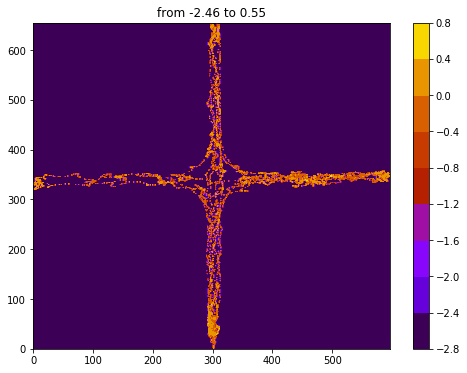

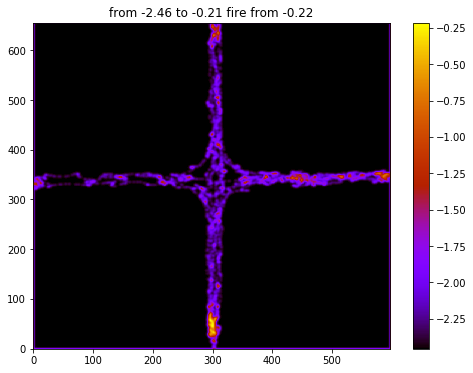

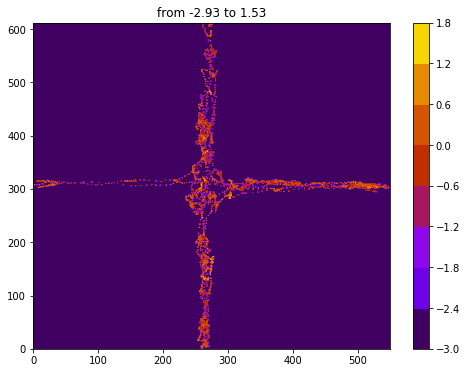

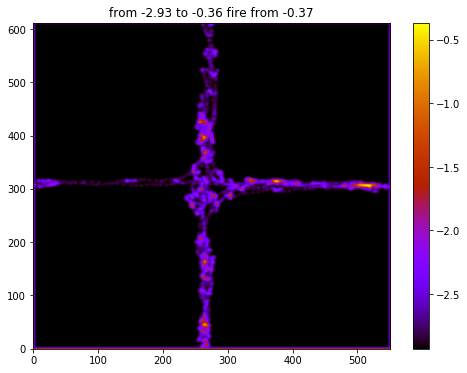

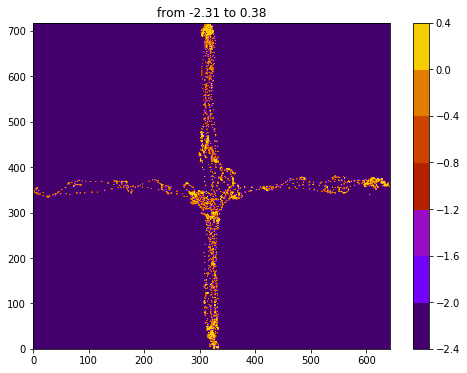

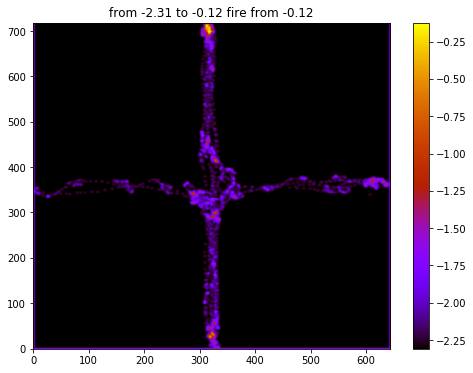

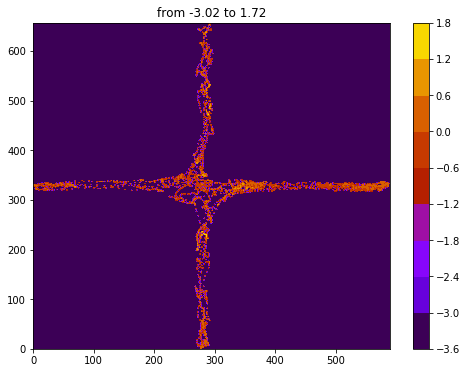

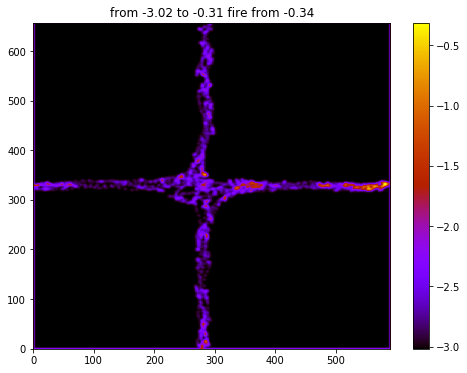

In [109]:
camp = 'gnuplot'

for i in range(len(desired_WT_NULL_List)):
    
    mouse_name = desired_WT_NULL_List[i]
    
    if mouse_name.split('_')[0] in ['NC128','NC102', 'NC013']:
        fps = 20
    else:
        fps = 15
    
    file_name = mouse_name + '_Average_Spatial_Activity.csv'
    
    df_norm_act = pd.read_csv(os.path.join(root_path_activity, file_name))

    # get all neuron avg activity
    df_norm_act_all = pd.DataFrame()
    df_norm_act_all['all_neuron_avg'] = df_norm_act.iloc[:, :-2].mean(axis = 1)
    df_norm_act_all['X'] = df_norm_act['X'].values.tolist()
    df_norm_act_all['Y'] = df_norm_act['Y'].values.tolist()

    AllNeuron_img_array, AllNeuron_img_array_sm = img_array(df_norm_act_all, neuron_index = 0, 
                                                            sigma_x = 2.0, sigma_y = 2.0, PAD=False, padder = None)

    # plot
    # original location
    plt.figure(figsize = (8,6))
    fig = plt.contourf(AllNeuron_img_array,  cmap = camp)
    plt.colorbar()
    plt.title('from '+str("{:.2f}".format(AllNeuron_img_array.min()))+' to '+str("{:.2f}".format(AllNeuron_img_array.max())))
    plt.savefig(mouse_name +'_AllNeuron.png')

    # smoothed location
    plt.figure(figsize = (8,6))
    plt.imshow(AllNeuron_img_array_sm, cmap = camp,
               interpolation='nearest', aspect='auto',origin='lower')
    plt.colorbar()
    plt.title('from ' + str("{:.2f}".format(AllNeuron_img_array_sm.min()))+
              ' to ' + str("{:.2f}".format(AllNeuron_img_array_sm.max()))+
             ' fire from ' + str("{:.2f}".format(np.partition(AllNeuron_img_array_sm.flatten(), -2)[-2])))
    plt.savefig(mouse_name +'_AllNeuron_Smoothed.png')



# all mice average 

- WT vs NULL
- want to see the comparison

WT ALL Get Average Spatial Activity Map And Plot


/Users/xiaoqiansun/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(26014, 17)
neuron_index:  0
xmin: 301.0  xmax: 1036.0  ymin: 27.0  ymax: 707.0  zmin: -1.6259839333333332  zmax: 3.3440729166666667
img_array shape:  (750, 750)
smoothed z min -2.625983933333333 smoothed z max 0.19025671839512287
--------------------------------------------


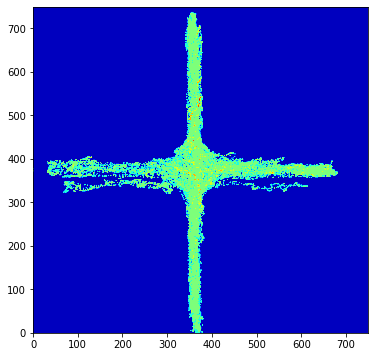

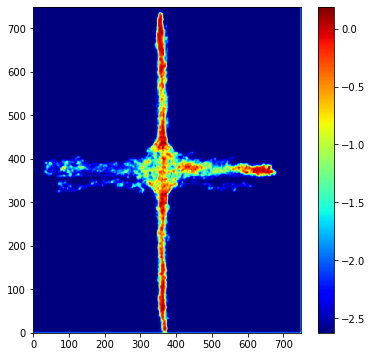

In [85]:
WT_df_openP_list = []
root_path_activity = r'/Users/xiaoqiansun/Desktop/MedLu/EPM/EPM_Data/Average_Spatial_Activity'
EPM_root_path_on_off_summary = r'/Users/xiaoqiansun/Desktop/MedLu/EPM/EPM_Data/ON_OFF_Summary'

print('WT ALL Get Average Spatial Activity Map And Plot')

for i in range(len(WT_list)):
    
    mouse_name = WT_list[i]
    
    if mouse_name.split('_')[0] in ['NC128','NC102', 'NC013']:
        fps = 20
    else:
        fps = 15
    
    
    # read in EPM ON/OFF summary dataframe
    #----------------------------------------------------------------------------------
    project = 'EPM'
    EPM_file_name = project+'_A_Summary_'+mouse_name+'_ONOFF.csv'
    EPM_on_off_df = pd.read_csv(os.path.join(EPM_root_path_on_off_summary, EPM_file_name))
    EPM_columns = EPM_on_off_df.columns.to_list()
    EPM_columns[0] = 'Neurons'
    EPM_on_off_df.columns = EPM_columns
    EPM_on_off_df = EPM_on_off_df.set_index('Neurons')
    openPON_neurons = EPM_on_off_df[EPM_on_off_df['openPreferedON'] == 1].index.to_list()
    openPON_neurons.append("X")
    openPON_neurons.append("Y")
    
    # openP On norm act
    #----------------------------------------------------------------------------------
    file_name = mouse_name + '_Average_Spatial_Activity.csv'
    df_norm_act = pd.read_csv(os.path.join(root_path_activity, file_name))
    df_norm_act_openP = df_norm_act[openPON_neurons]
    df_norm_act_openP['all_neuron_avg'] = df_norm_act_openP.iloc[:, :-2].mean(axis = 1)
    df_norm_act_openP = df_norm_act_openP[['X', 'Y', 'all_neuron_avg']]
    df_norm_act_openP = df_norm_act_openP.set_index(['X', 'Y'])
    WT_df_openP_list.append(df_norm_act_openP)

WT_df_openP_All = pd.concat(WT_df_openP_list, axis=1)  
WT_df_openP_All['mean'] = WT_df_openP_All.mean(axis = 1)
print(WT_df_openP_All.shape)
WT_df_openP_All = WT_df_openP_All[["mean"]]
WT_df_openP_All = WT_df_openP_All.reset_index()
WT_df_openP_All = WT_df_openP_All.dropna()
WT_df_openP_All = WT_df_openP_All[['mean', 'X', 'Y']]
#WT_df_openP_All.head()

AllNeuron_img_array, AllNeuron_img_array_sm = img_array(WT_df_openP_All, neuron_index = 0,
                                                    sigma_x = 2.0, sigma_y = 2.0, PAD=False, padder = None,
                                                    shape = (750, 750))

# plot
# original location
plt.figure(figsize = (6,6))
camp = 'jet'
fig = plt.contourf(AllNeuron_img_array,  cmap=camp)
plt.savefig('WT_openPON.png')

# smoothed location
plt.figure(figsize = (6,6))
plt.imshow(AllNeuron_img_array_sm, 
           cmap='jet', 
           interpolation='nearest', aspect='auto',
           origin='lower', 
          #vmin=-3, vmax=0
          )
plt.savefig('WT_openPON_Smoothed.png')
plt.colorbar()

NULL ALL Get Average Spatial Activity Map And Plot


/Users/xiaoqiansun/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(24568, 15)
neuron_index:  0
xmin: 300.0  xmax: 1045.0  ymin: 26.0  ymax: 708.0  zmin: -3.754507  zmax: 9.038869
img_array shape:  (750, 750)
smoothed z min -4.754507 smoothed z max 0.1906327338433767
--------------------------------------------


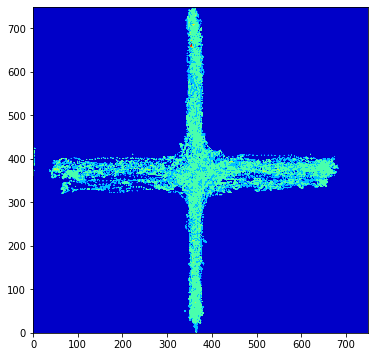

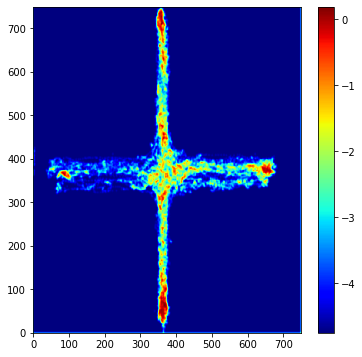

In [86]:
NULL_df_openP_list = []
root_path_activity = r'/Users/xiaoqiansun/Desktop/MedLu/EPM/EPM_Data/Average_Spatial_Activity'
EPM_root_path_on_off_summary = r'/Users/xiaoqiansun/Desktop/MedLu/EPM/EPM_Data/ON_OFF_Summary'

print('NULL ALL Get Average Spatial Activity Map And Plot')

for i in range(len(NULL_list)):
    
    mouse_name = NULL_list[i]
    
    if mouse_name.split('_')[0] in ['NC128','NC102', 'NC013']:
        fps = 20
    else:
        fps = 15
    
    
    # read in EPM ON/OFF summary dataframe
    #----------------------------------------------------------------------------------
    project = 'EPM'
    EPM_file_name = project+'_A_Summary_'+mouse_name+'_ONOFF.csv'
    EPM_on_off_df = pd.read_csv(os.path.join(EPM_root_path_on_off_summary, EPM_file_name))
    EPM_columns = EPM_on_off_df.columns.to_list()
    EPM_columns[0] = 'Neurons'
    EPM_on_off_df.columns = EPM_columns
    EPM_on_off_df = EPM_on_off_df.set_index('Neurons')
    openPON_neurons = EPM_on_off_df[EPM_on_off_df['openPreferedON'] == 1].index.to_list()
    openPON_neurons.append("X")
    openPON_neurons.append("Y")
    
    # openP On norm act
    #----------------------------------------------------------------------------------
    file_name = mouse_name + '_Average_Spatial_Activity.csv'
    df_norm_act = pd.read_csv(os.path.join(root_path_activity, file_name))
    df_norm_act_openP = df_norm_act[openPON_neurons]
    df_norm_act_openP['all_neuron_avg'] = df_norm_act_openP.iloc[:, :-2].mean(axis = 1)
    df_norm_act_openP = df_norm_act_openP[['X', 'Y', 'all_neuron_avg']]
    df_norm_act_openP = df_norm_act_openP.set_index(['X', 'Y'])
    NULL_df_openP_list.append(df_norm_act_openP)

NULL_df_openP_All = pd.concat(NULL_df_openP_list, axis=1)  
NULL_df_openP_All['mean'] = NULL_df_openP_All.mean(axis = 1)
print(NULL_df_openP_All.shape)
NULL_df_openP_All = NULL_df_openP_All[["mean"]]
NULL_df_openP_All = NULL_df_openP_All.reset_index()
NULL_df_openP_All = NULL_df_openP_All.dropna()
NULL_df_openP_All = NULL_df_openP_All[['mean', 'X', 'Y']]
#NULL_df_openP_All.head()

AllNeuron_img_array, AllNeuron_img_array_sm = img_array(NULL_df_openP_All, neuron_index = 0,
                                                    sigma_x = 2.0, sigma_y = 2.0, PAD=False, padder = None,
                                                    shape = (750, 750))

# plot
# original location
plt.figure(figsize = (6,6))
camp = 'jet'
fig = plt.contourf(AllNeuron_img_array,  cmap=camp)
plt.savefig('NULL_openPON.png')

# smoothed location
plt.figure(figsize = (6,6))
plt.imshow(AllNeuron_img_array_sm, 
           cmap='jet', 
           interpolation='nearest', aspect='auto',
           origin='lower', 
          #vmin=-3, vmax=0
          )
plt.savefig('NULL_openPON_Smoothed.png')
plt.colorbar()